# Import Library

In [3]:
import numpy as np
import scipy.io
from scipy.signal import stft, get_window
from sklearn.preprocessing import  MinMaxScaler, LabelBinarizer
from sklearn.feature_selection import  mutual_info_classif
from scipy.stats import f_oneway, skew, kurtosis
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,  roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

# Data Preprocessing

In [4]:
# Define the directory containing the EEG data
directory = os.path.join("./", "EEG Data")

# Construct the full file path
file_path = os.path.join(directory, "eeg_record1.mat")

# Load the .mat file
file = scipy.io.loadmat(file_path)

# Extract the EEG data from the file (assuming it follows the same structure)
eeg_data = file["o"]["data"][0, 0]

# Convert the data to a pandas DataFrame
eeg_df = pd.DataFrame.from_dict(eeg_data)

# List of original features of the data
columns = [
    "ED_COUNTER",
    "ED_INTERPOLATED",
    "ED_RAW_CQ",
    "ED_AF3",
    "ED_F7",
    "ED_F3",
    "ED_FC5",
    "ED_T7",
    "ED_P7",
    "ED_O1",
    "ED_O2",
    "ED_P8",
    "ED_T8",
    "ED_FC6",
    "ED_F4",
    "ED_F8",
    "ED_AF4",
    "ED_GYROX",
    "ED_GYROY",
    "ED_TIMESTAMP",
    "ED_ES_TIMESTAMP",
    "ED_FUNC_ID",
    "ED_FUNC_VALUE",
    "ED_MARKER",
    "ED_SYNC_SIGNAL",
]

eeg_df.columns = columns
eeg_df.head()

ED_COUNTER  ED_INTERPOLATED  ED_RAW_CQ       ED_AF3        ED_F7  \
0         3.0              0.0      463.0  4440.000000  4417.948718   
1         4.0              0.0        0.0  4439.487179  4417.948718   
2         5.0              0.0      447.0  4438.974359  4414.871795   
3         6.0              0.0      500.0  4438.974359  4410.256410   
4         7.0              0.0      424.0  4439.487179  4407.179487   

         ED_F3       ED_FC5        ED_T7        ED_P7        ED_O1  ...  \
0  5390.769231  3833.846154  4019.487179  4656.410256  4742.051282  ...   
1  5389.230769  3830.256410  4020.000000  4658.974359  4738.974359  ...   
2  5385.641026  3829.743590  4017.948718  4655.897436  4734.358974  ...   
3  5381.025641  3831.794872  4016.410256  4649.230769  4730.256410  ...   
4  5378.461538  3831.282051  4019.487179  4647.692308  4729.230769  ...   

         ED_F8       ED_AF4  ED_GYROX  ED_GYROY  ED_TIMESTAMP  \
0  4335.384615  4563.589744    1573.0    1726.0       764.304   
1  4331.794872  4566.666667    1570.0    1727.0       764.304   
2  4333.846154  4557.948718    1567.0    1726.0       764.304   
3  4334.358974  4552.820513    1564.0    1723.0       764.304   
4  4334.358974  4546.666667    1565.0    1720.0       764.304   

   ED_ES_TIMESTAMP  ED_FUNC_ID  ED_FUNC_VALUE  ED_MARKER  ED_SYNC_SIGNAL  
0         0.031277         0.0            0.0        0.0             0.0  
1         0.031277         0.0            0.0        0.0             0.0  
2         0.031277         0.0            0.0        0.0             0.0  
3         0.031277         0.0            0.0        0.0             0.0  
4         0.031277         0.0            0.0        0.0             0.0  

[5 rows x 25 columns]

## Extract data channels

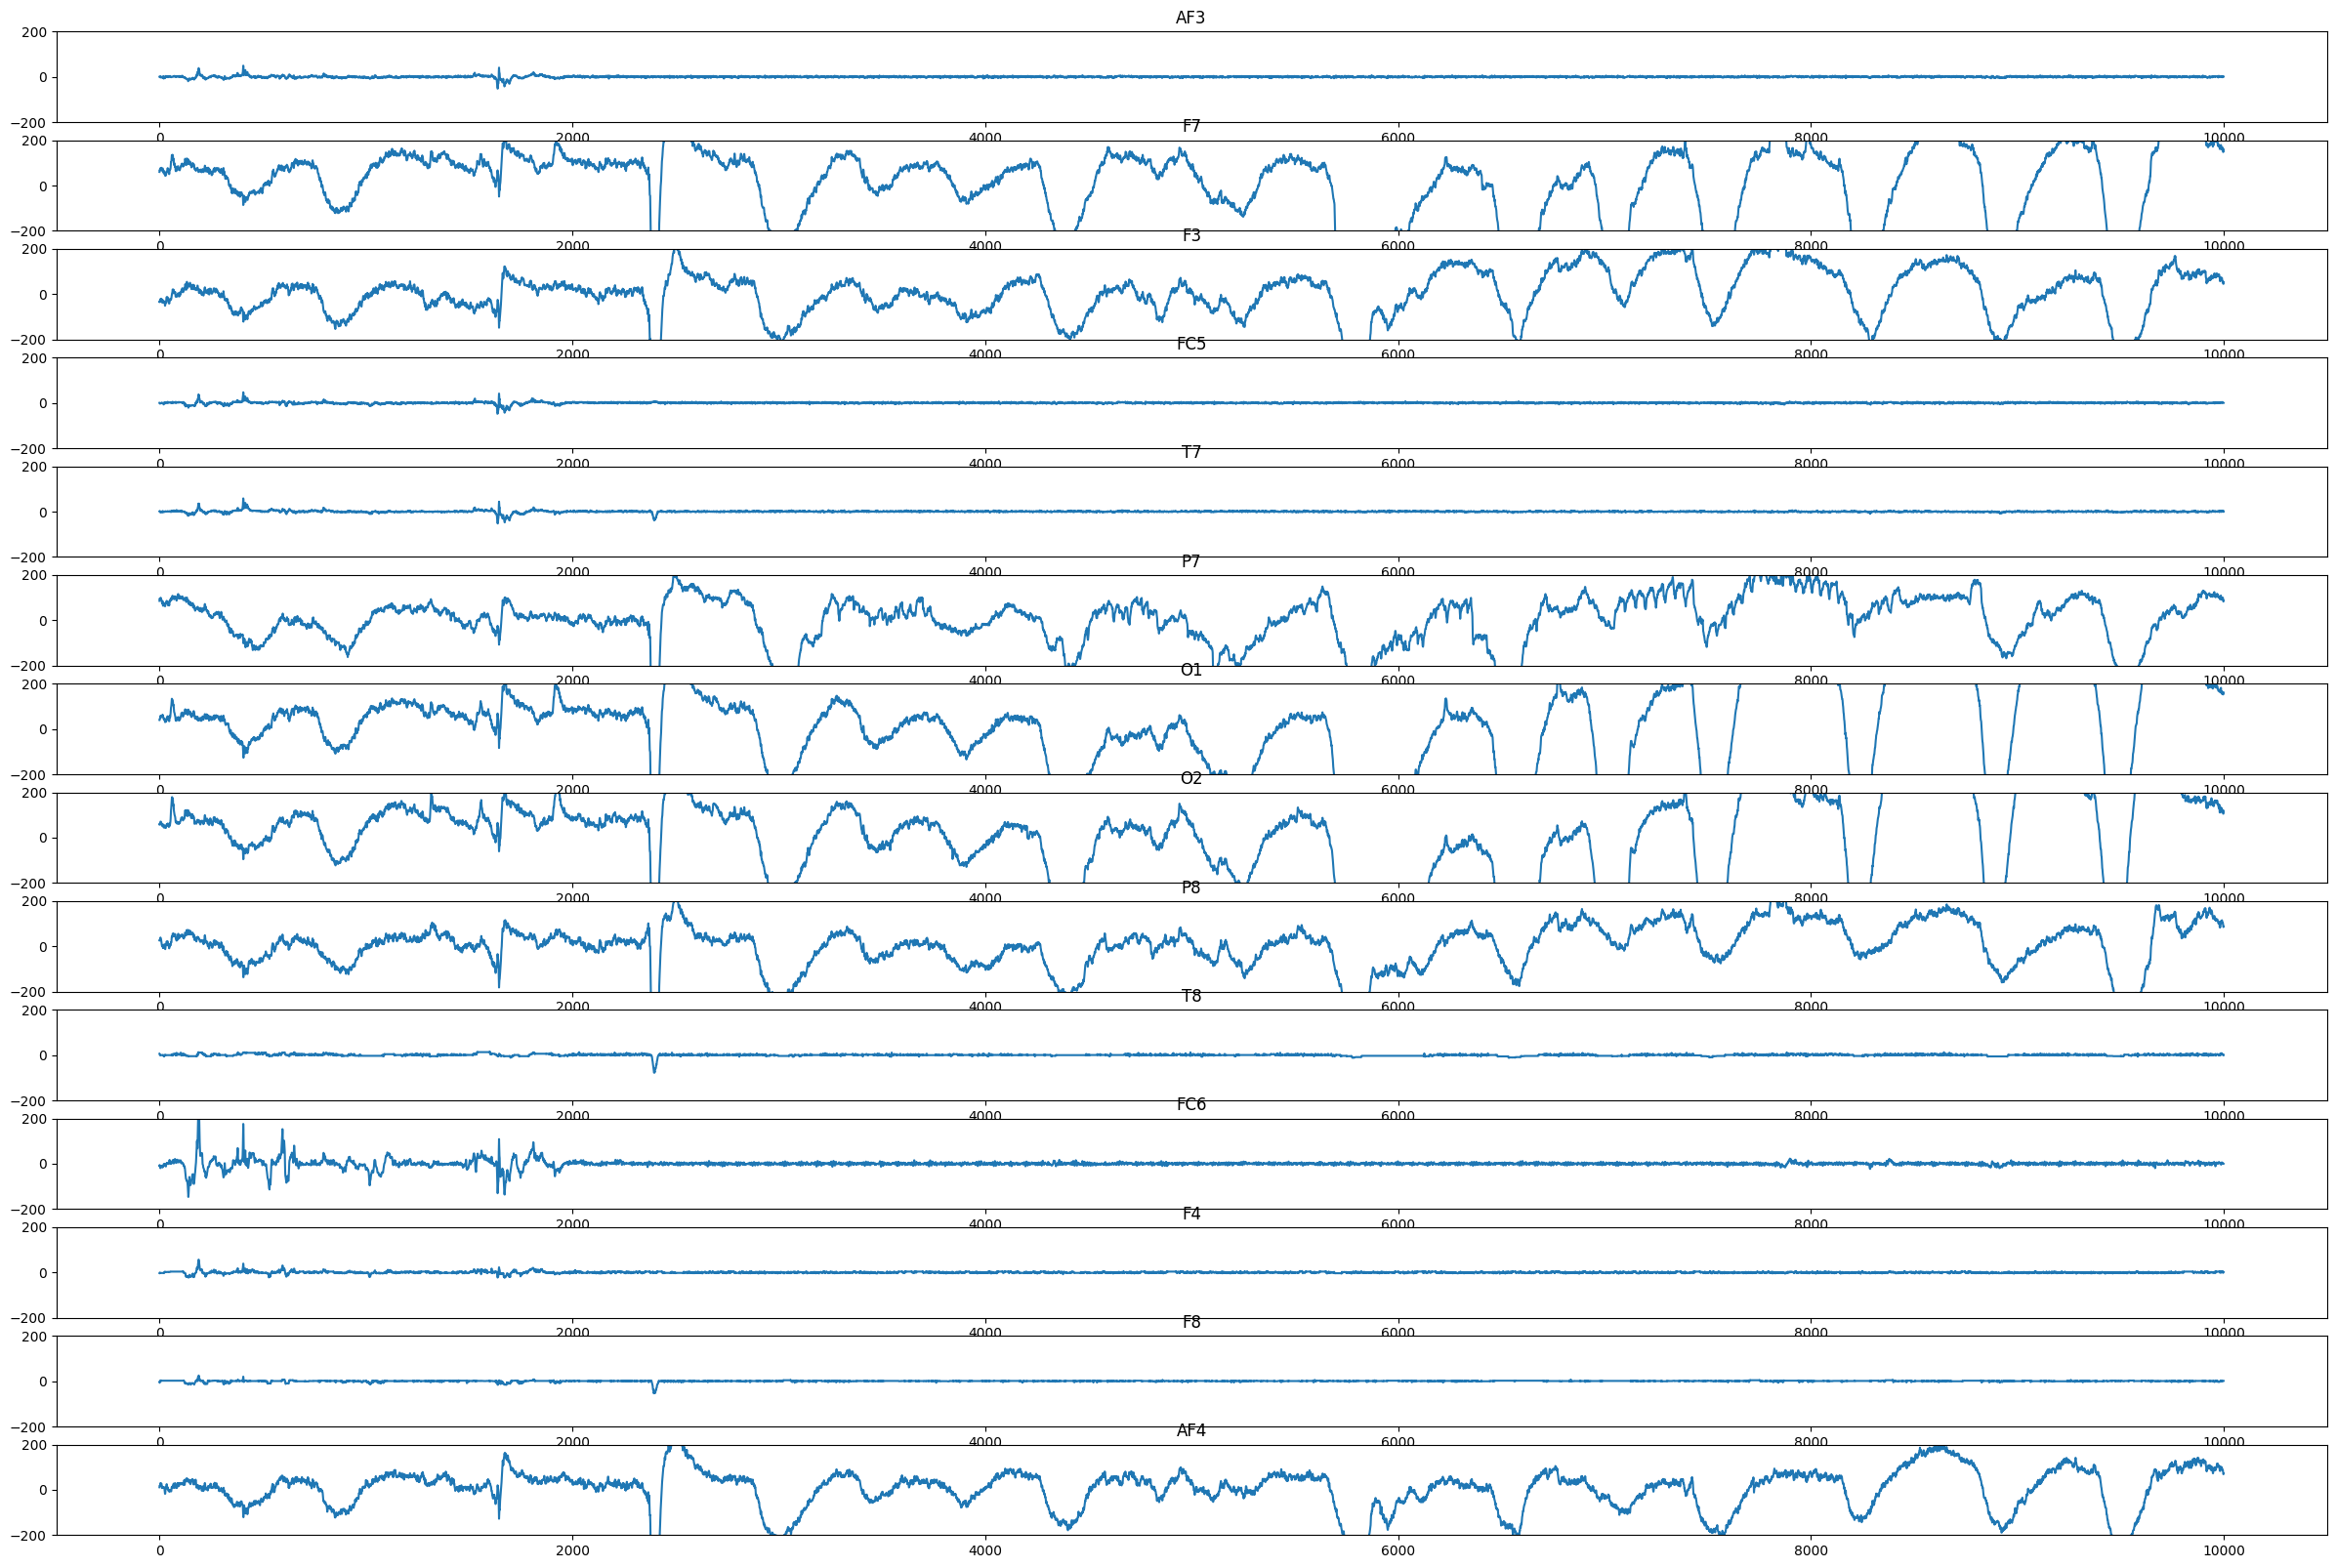

In [5]:
file = scipy.io.loadmat(file_path)
data = file["o"]["data"][0, 0]

# EEG data is in channels 4 to 17
channels = [
    "AF3",
    "F7",
    "F3",
    "FC5",
    "T7",
    "P7",
    "O1",
    "O2",
    "P8",
    "T8",
    "FC6",
    "F4",
    "F8",
    "AF4",
]

# Visualize the data
fig, ax = plt.subplots(14, 1)
fig.set_figwidth(20)
fig.set_figheight(50)
fig.set_size_inches(30, 20)
for i in range(14):
    data_ave = data[5000:15000, i + 3] - np.mean(data[5000:15000, i + 3])
    ax[i].plot(data_ave)
    ax[i].set_title(channels[i])
    ax[i].set_ylim(-200, 200)

*Sau khi plot các điểm dữ liệu của record đại diện eeg_record1.mat, ta có thể nhìn thấy hoạt động của các channel. Rõ ràng chỉ có 7 channel hoạt động nổi bật (có thể gọi là có mức đóng góp cao nhất). Vì thế ta có thể chọn 7 channel này làm USEFUL_CHANNELS. Các channel này gồm:* **F7, F3, P7, O1, O2, P8, AF4**

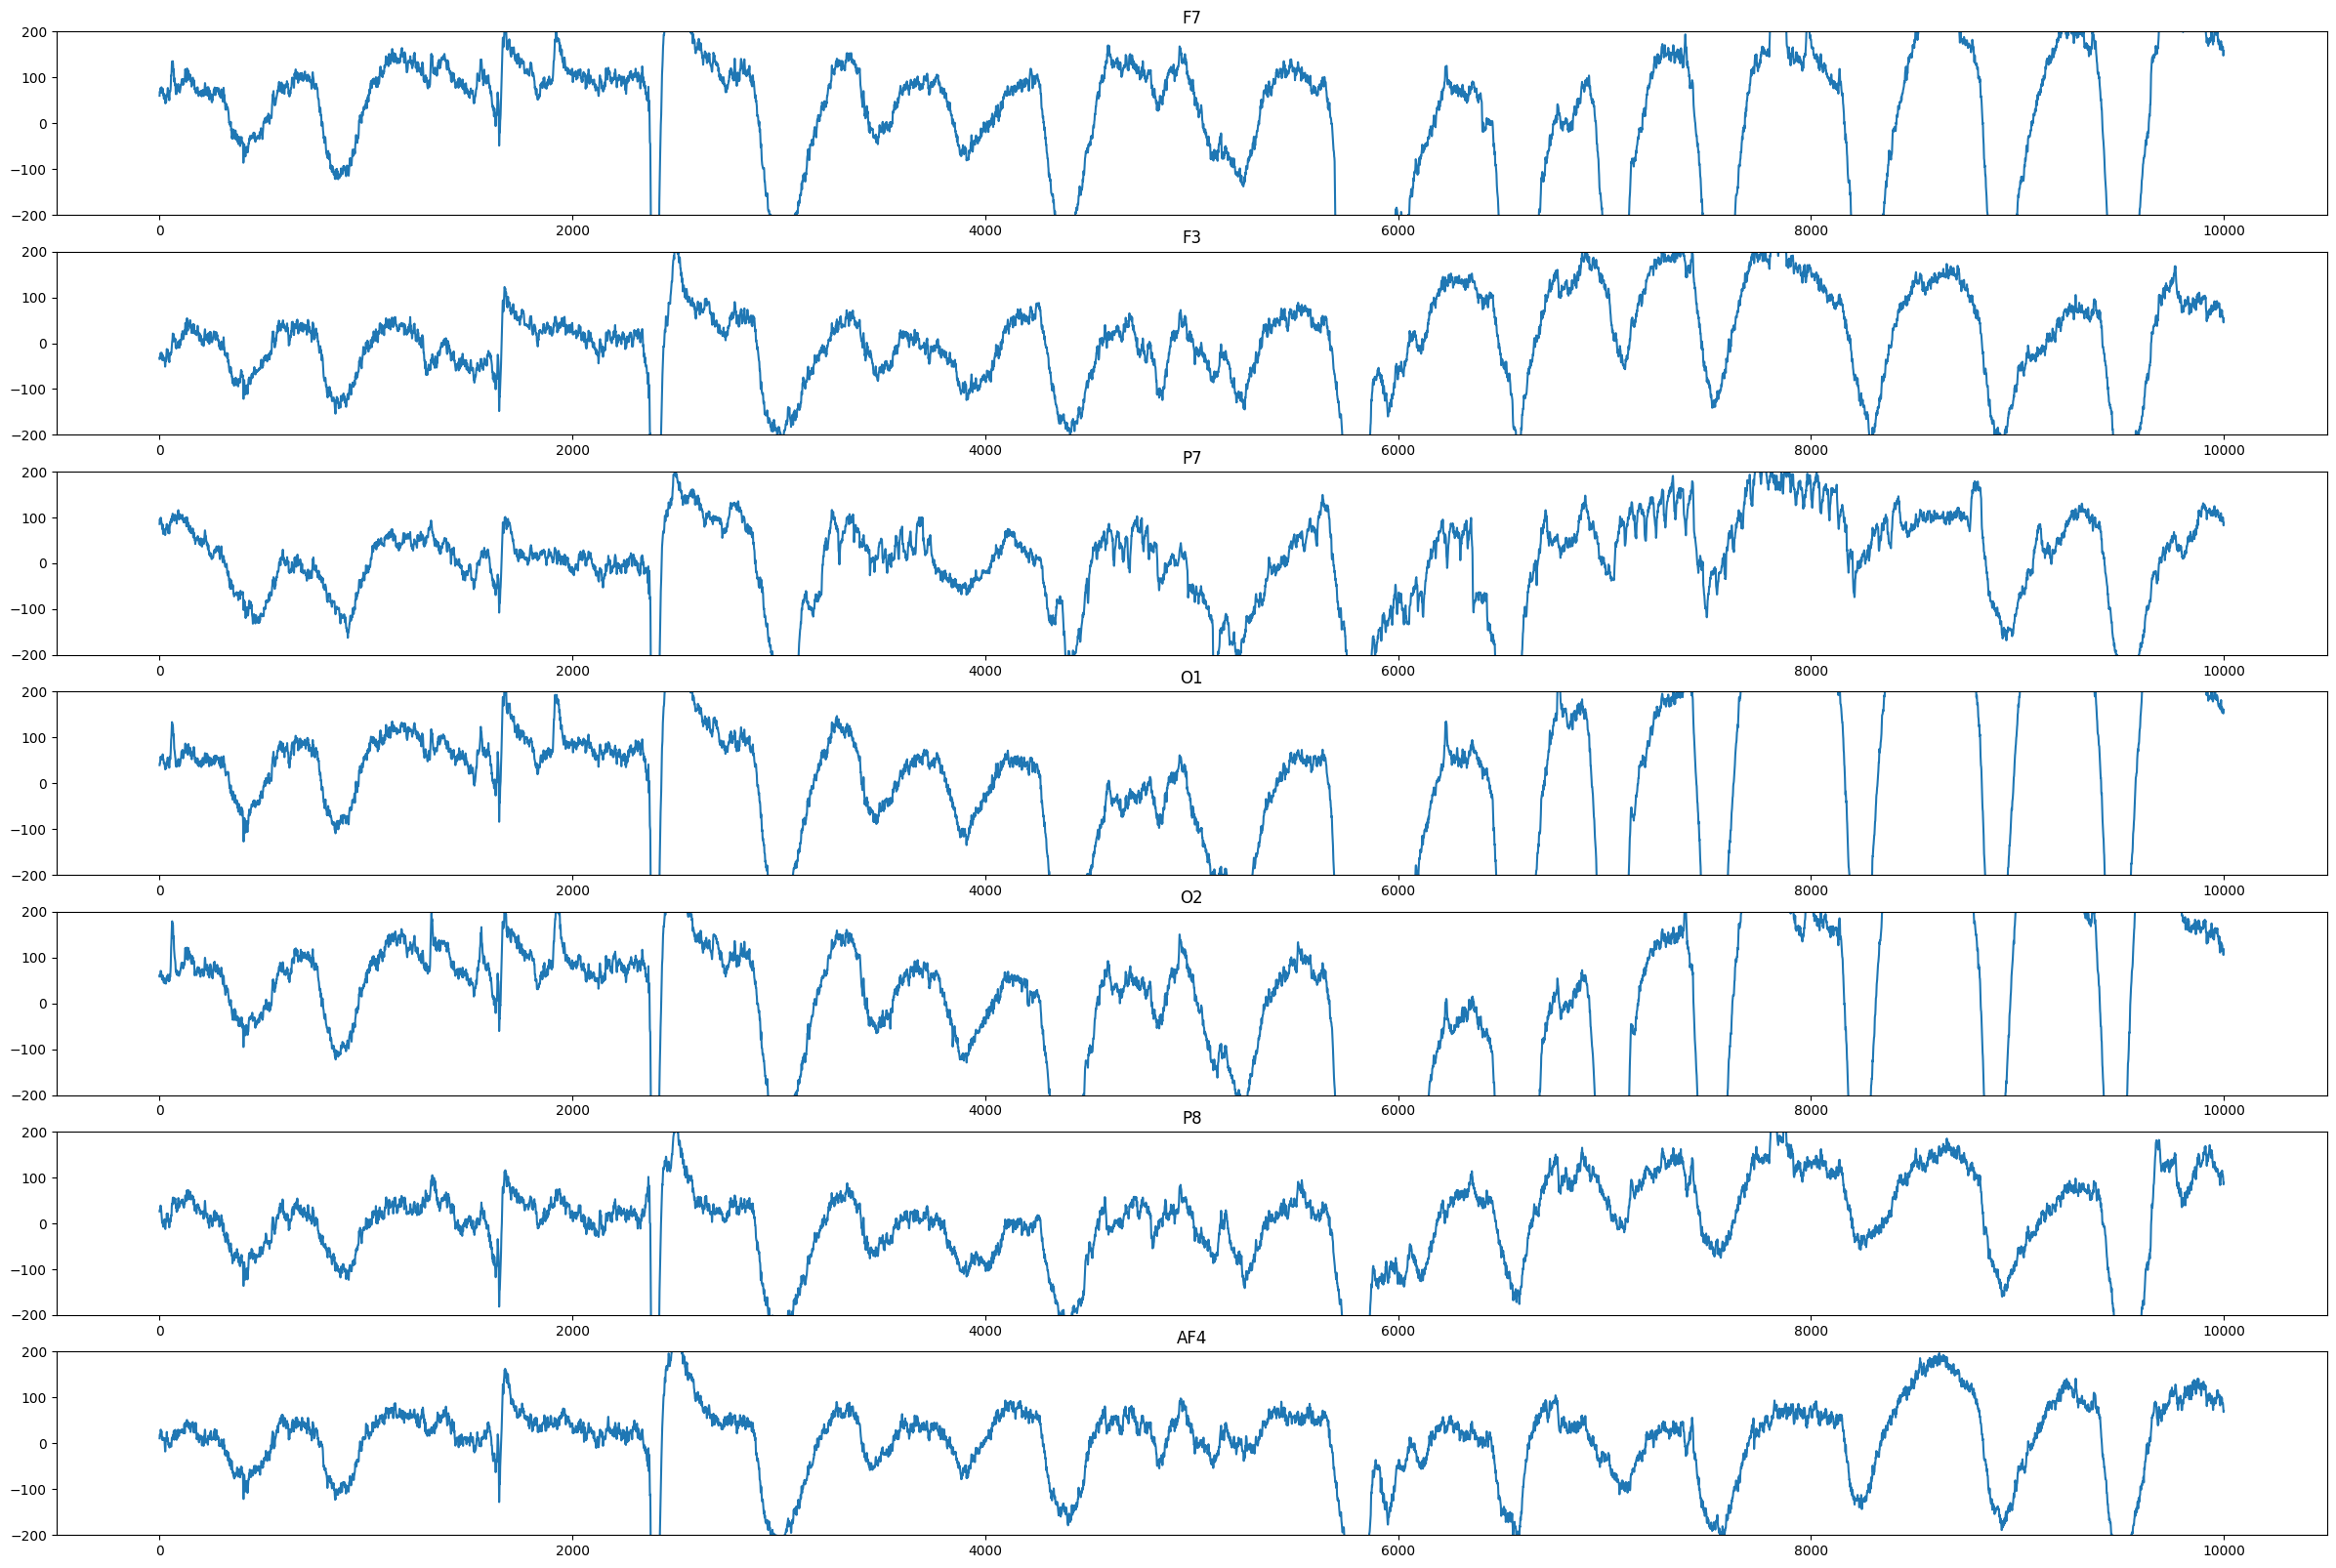

In [6]:
# Get the USEFUL_CHANNELS
USEFUL_CHANNELS = np.array([1, 2, 5, 6, 7, 8, 13]) + 3
channels = ["F7", "F3", "P7", "O1", "O2", "P8", "AF4"]
# Visualize the data
fig, ax = plt.subplots(7, 1)
fig.set_figwidth(20)
fig.set_figheight(50)
fig.set_size_inches(30, 20)
for i, j in enumerate(USEFUL_CHANNELS):
    data_ave = data[5000:15000, j] - np.mean(data[5000:15000, j])
    ax[i].plot(data_ave)
    ax[i].set_title(channels[i])
    ax[i].set_ylim(-200, 200)

## Loading data and feature engineering

In [7]:
def get_EEG_data(data_root, filename):
    """
    Extract EEG data from a single file, filter specific channels,
    and add labels for focus, unfocused, and drowsy states based on time.
    Args:
        data_root (str): Root directory containing EEG data files.
        filename (str): Filename of the EEG data file.
    Returns:
        pd.DataFrame: DataFrame containing the EEG data with selected channels and labels.
    """
    # Sampling frequency (Hz)
    hz = 128  # Number of samples per second

    # Load the .mat file
    mat = scipy.io.loadmat(os.path.join(data_root, filename))
    data = pd.DataFrame.from_dict(mat["o"]["data"][0, 0])

    # Limit the data to the 7 valid EEG leads
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))

    # Rename columns to EEG channel names
    channel_names = [
        "AF3",
        "F7",
        "F3",
        "FC5",
        "T7",
        "P7",
        "O1",
        "O2",
        "P8",
        "T8",
        "FC6",
        "F4",
        "F8",
        "AF4",
    ]
    dat.columns = channel_names

    # Filter the data to keep only the specified channels
    channels_to_keep = ["F7", "F3", "P7", "O1", "O2", "P8", "AF4"]
    dat = dat[channels_to_keep]

    # Only keep data for the first 30 minutes
    max_samples = int(30 * 60 * hz)
    dat = dat.iloc[:max_samples]

    # Create a label column based on time
    label_column = []
    for i in range(dat.shape[0]):
        time_in_minutes = (i / hz) / 60  # Convert sample index to minutes
        if time_in_minutes < 10:
            label_column.append(0)  # Focused
        elif 10 <= time_in_minutes < 20:
            label_column.append(1)  # Unfocused
        else:
            label_column.append(2)  # Drowsy

    # Add the label column to the DataFrame
    dat["Label"] = label_column

    return dat


def load_subject_data(Data_root, Subject_files):
    """
    Load EEG data for all files of a specific subject.
    Args:
        data_root (str): Root directory containing EEG data files.
        subject_files (list): List of filenames for the subject.
    Returns:
        pd.DataFrame: Concatenated EEG data for the subject.
    """
    subject_data = []

    for filename in Subject_files:
        eeg_data = get_EEG_data(Data_root, filename)
        print(f"Loaded {filename} with shape {eeg_data.shape}")
        subject_data.append(eeg_data)

    # Concatenate all the EEG data for the subject
    subject_data = pd.concat(subject_data, ignore_index=True)
    subject_data.sort_values(by="Label", inplace=True)
    return subject_data

In [8]:
def feature_engineering_eegdata_with_labels(
    eeg_data,
    sampling_freq=128,
    step_size_seconds=1,
    max_freq=18,
    bin_size=0.5,
):
    """
    Preprocess raw EEG data using STFT and assign labels based on the dominant label in each time window.
    Converts power to decibels and combines all channels into a joint feature vector.

    Args:
        eeg_data (pd.DataFrame): Raw EEG data with channels as columns and a "Label" column.
        sampling_freq (int): Sampling frequency in Hz (default: 128 Hz).
        dft_points (int): Number of points for the discrete Fourier transform (default: 1024).
        step_size_seconds (int): Step size for STFT in seconds (default: 1 second).
        max_freq (int): Maximum frequency to retain in Hz (default: 18 Hz).
        bin_size (float): Size of each frequency bin in Hz (default: 0.5 Hz).

    Returns:
        pd.DataFrame: Preprocessed data with features for each time point and labels.
    """
    # Extract the "Label" column and drop it from EEG data
    labels = eeg_data["Label"].to_numpy()
    eeg_data = eeg_data.drop(columns=["Label"])

    # Constants
    step_size_samples = int(step_size_seconds * sampling_freq)  # Step size in samples
    freq_bins = np.arange(0.5, max_freq + bin_size, bin_size)  # Frequency bin edges
    window = get_window("blackman", 1920)  # Blackman window for STFT (15-second window)
    all_features = []  # Store joint feature vectors
    all_labels = []  # Store labels for each time window

    for channel in eeg_data.columns:
        print(f"Processing channel: {channel}")
        channel_data = eeg_data[channel].to_numpy()

        # Compute STFT
        f, t, Zxx = stft(
            channel_data,
            fs=sampling_freq,
            window=window,
            nperseg=1920,
            noverlap=1920 - step_size_samples,
        )
        power_spectrum = np.abs(Zxx) ** 2  # Compute the power spectrum

        # Restrict frequencies to the range 0.5 Hz to max_freq
        binned_spectrum = np.zeros((len(freq_bins) - 1, power_spectrum.shape[1]))
        for i in range(len(freq_bins) - 1):
            freq_mask = (f >= freq_bins[i]) & (f < freq_bins[i + 1])
            binned_spectrum[i, :] = np.mean(power_spectrum[freq_mask, :], axis=0)

        # Convert power to decibels
        binned_spectrum_db = 10 * np.log10(binned_spectrum + 1e-10)

        # Append features for this channel
        all_features.append(binned_spectrum_db.T)

    # Combine features from all channels into a single joint feature vector per time point
    combined_features = np.hstack(all_features)

    # Generate feature column names
    feature_columns = [
        f"Channel_{channel}_Freq_{freq_bins[i]:.1f}-{freq_bins[i + 1]:.1f}Hz"
        for channel in range(1, len(eeg_data.columns) + 1)
        for i in range(len(freq_bins) - 1)
    ]

    # Map labels to the corresponding STFT windows using dominance logic
    window_size_samples = 1920  # 15-second window
    for start_time in t:  # t contains the start times of the STFT windows
        start_sample = int(start_time * sampling_freq)
        end_sample = start_sample + window_size_samples

        # Find the dominant label in the window
        label_counts = {}
        for i in range(start_sample, end_sample):
            if 0 <= i < len(labels):
                label = labels[i]
                label_counts[label] = label_counts.get(label, 0) + 1

        # Assign the dominant label (most frequent)
        dominant_label = max(label_counts, key=label_counts.get, default=None)
        all_labels.append(dominant_label)

    # Create DataFrame with processed features and labels
    processed_data = pd.DataFrame(combined_features, columns=feature_columns)
    processed_data["Label"] = all_labels
    print(processed_data["Label"].head())
    print(f"Final processed data shape: {processed_data.shape}")
    print(processed_data["Label"].value_counts())

    return processed_data

In [9]:
subject_file_map = {
    "subject_1": [
        "eeg_record1.mat",
        "eeg_record2.mat",
        "eeg_record3.mat",
        "eeg_record4.mat",
        "eeg_record5.mat",
        "eeg_record6.mat",
        "eeg_record7.mat",
    ],
    "subject_2": [
        "eeg_record8.mat",
        "eeg_record9.mat",
        "eeg_record10.mat",
        "eeg_record11.mat",
        "eeg_record12.mat",
        "eeg_record13.mat",
        "eeg_record14.mat",
    ],
    "subject_3": [
        "eeg_record15.mat",
        "eeg_record16.mat",
        "eeg_record17.mat",
        "eeg_record18.mat",
        "eeg_record19.mat",
        "eeg_record20.mat",
        "eeg_record21.mat",
    ],
    "subject_4": [
        "eeg_record22.mat",
        "eeg_record23.mat",
        "eeg_record24.mat",
        "eeg_record25.mat",
        "eeg_record26.mat",
        "eeg_record27.mat",
        "eeg_record28.mat",
    ],
    "subject_5": [
        "eeg_record29.mat",
        "eeg_record30.mat",
        "eeg_record31.mat",
        "eeg_record32.mat",
        "eeg_record33.mat",
        "eeg_record34.mat",
    ],
}

data_root = "./EEG Data"

In [10]:
subject1_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_1"]
)
subject2_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_2"]
)
subject3_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_3"]
)
subject4_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_4"]
)
subject5_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_5"]
)

# print the shape of the data for each subject
print(subject1_data.shape)
print(subject2_data.shape)
print(subject3_data.shape)
print(subject4_data.shape)
print(subject5_data.shape)

Loaded eeg_record1.mat with shape (230400, 8)
Loaded eeg_record2.mat with shape (230400, 8)
Loaded eeg_record3.mat with shape (230400, 8)
Loaded eeg_record4.mat with shape (230400, 8)
Loaded eeg_record5.mat with shape (230400, 8)
Loaded eeg_record6.mat with shape (230400, 8)
Loaded eeg_record7.mat with shape (230400, 8)
Loaded eeg_record8.mat with shape (230400, 8)
Loaded eeg_record9.mat with shape (230400, 8)
Loaded eeg_record10.mat with shape (230400, 8)
Loaded eeg_record11.mat with shape (230400, 8)
Loaded eeg_record12.mat with shape (230400, 8)
Loaded eeg_record13.mat with shape (230400, 8)
Loaded eeg_record14.mat with shape (230400, 8)
Loaded eeg_record15.mat with shape (230400, 8)
Loaded eeg_record16.mat with shape (230400, 8)
Loaded eeg_record17.mat with shape (230400, 8)
Loaded eeg_record18.mat with shape (230400, 8)
Loaded eeg_record19.mat with shape (230400, 8)
Loaded eeg_record20.mat with shape (230400, 8)
Loaded eeg_record21.mat with shape (230400, 8)
Loaded eeg_record22.ma

In [11]:
# Preprocess data
subject1_preprocessed_data = feature_engineering_eegdata_with_labels(
    eeg_data=subject1_data
)
subject2_preprocessed_data = feature_engineering_eegdata_with_labels(
    eeg_data=subject2_data
)
subject3_preprocessed_data = feature_engineering_eegdata_with_labels(
    eeg_data=subject3_data
)
subject4_preprocessed_data = feature_engineering_eegdata_with_labels(
    eeg_data=subject4_data
)
subject5_preprocessed_data = feature_engineering_eegdata_with_labels(
    eeg_data=subject5_data
)

# Drop rows with NaN values
subject1_preprocessed_data = subject1_preprocessed_data.dropna(subset=["Label"])
subject2_preprocessed_data = subject2_preprocessed_data.dropna(subset=["Label"])
subject3_preprocessed_data = subject3_preprocessed_data.dropna(subset=["Label"])
subject4_preprocessed_data = subject4_preprocessed_data.dropna(subset=["Label"])
subject5_preprocessed_data = subject5_preprocessed_data.dropna(subset=["Label"])

Processing channel: F7
Processing channel: F3
Processing channel: P7
Processing channel: O1
Processing channel: O2
Processing channel: P8
Processing channel: AF4
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Label, dtype: float64
Final processed data shape: (12601, 246)
Label
2.0    4207
1.0    4200
0.0    4193
Name: count, dtype: int64
Processing channel: F7
Processing channel: F3
Processing channel: P7
Processing channel: O1
Processing channel: O2
Processing channel: P8
Processing channel: AF4
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Label, dtype: float64
Final processed data shape: (12601, 246)
Label
2.0    4207
1.0    4200
0.0    4193
Name: count, dtype: int64
Processing channel: F7
Processing channel: F3
Processing channel: P7
Processing channel: O1
Processing channel: O2
Processing channel: P8
Processing channel: AF4
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Label, dtype: float64
Final processed data shape: (12601, 246)
Label
2.0    4207
1.0    4200
0.0   

# Visualize

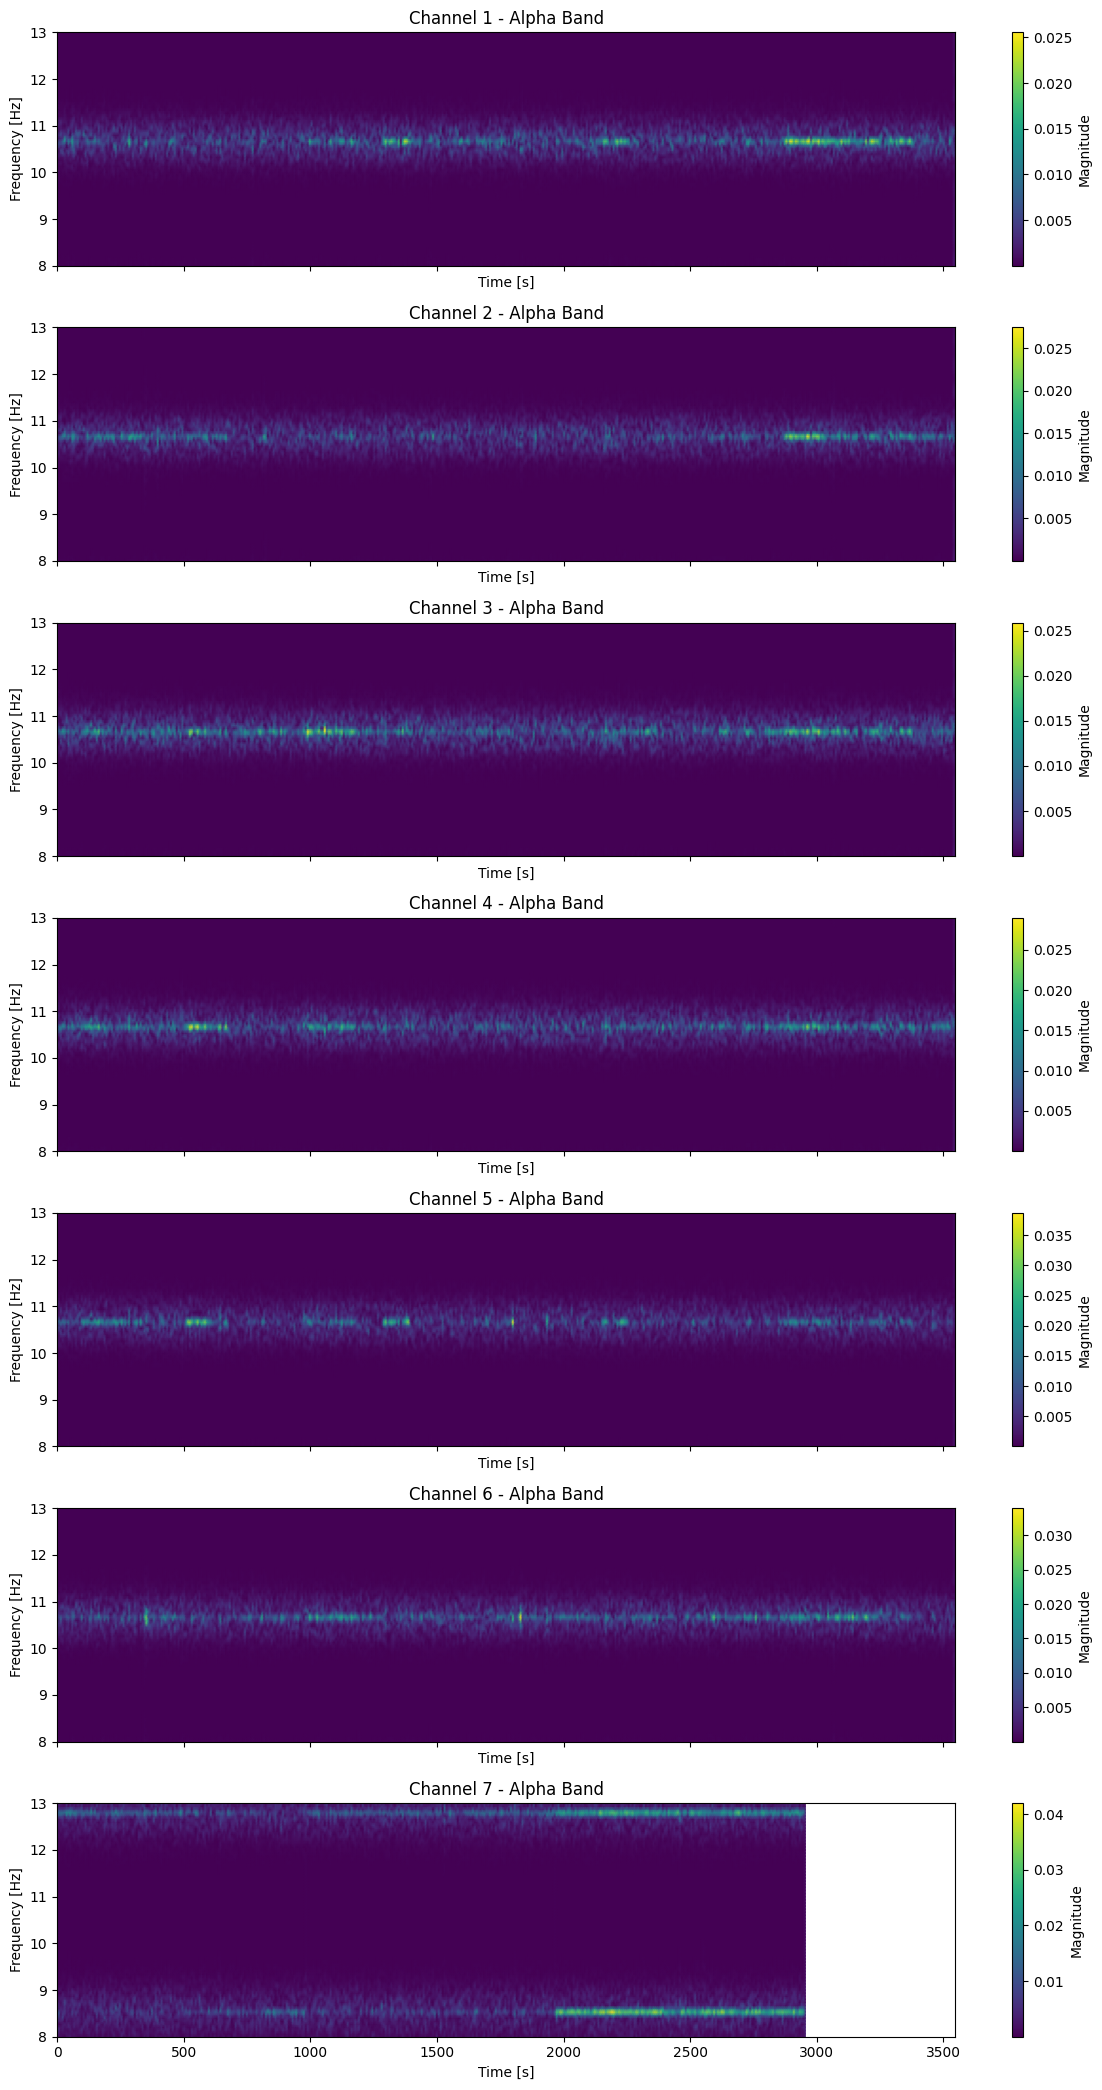

In [12]:
def plot_all_channel_spectrogram(
    processed_data, fs=128, band_name="Alpha", nperseg=1920
):
    """
    Plot spectrogram for specific bands for all channels in same subplot.

    Args:
        processed_data (pd.DataFrame): Preprocessed data (features).
        fs (int): Sample frequency (Hz).
        band_name (str): Band name with Hz (Delta, Theta, Alpha, Beta).
        nperseg (int): Number of samples in each segment of STFT.
    """
    freq_bands = {
        "Delta": (0.5, 4),
        "Theta": (4, 8),
        "Alpha": (8, 13),
        "Beta": (13, 30),
    }
    # Freqency array
    freq_bins = np.array(
        [
            0.5,
            1.0,
            1.5,
            2.0,
            2.5,
            3.0,
            3.5,
            4.0,
            4.5,
            5.0,
            5.5,
            6.0,
            6.5,
            7.0,
            7.5,
            8.0,
            8.5,
            9.0,
            9.5,
            10.0,
            10.5,
            11.0,
            11.5,
            12.0,
            12.5,
            13.0,
            13.5,
            14.0,
            14.5,
            15.0,
            15.5,
            16.0,
            16.5,
            17.0,
            17.5,
            18.0,
        ]
    )

    band_freqs = freq_bands[band_name]
    num_channels = 7

    # Create subplot with channel
    fig, axes = plt.subplots(
        num_channels, 1, figsize=(12, 3 * num_channels), sharex=True, sharey=True
    )

    # Loop through all channels and plot spectrogram in respective subplot
    for channel_index in range(num_channels):
        # Taking data for channel in specific index
        channel_data = processed_data.iloc[
            :, channel_index * len(freq_bins) : (channel_index + 1) * len(freq_bins)
        ]

        # Normalize Data
        scaler = MinMaxScaler()
        scaled_channel_data = scaler.fit_transform(channel_data)

        # Calculate the Short-Time Fourier Transform (STFT)
        f, t, Zxx = stft(scaled_channel_data.flatten(), fs=fs, nperseg=nperseg)

        # Separate the band indices
        band_indices = np.where((f >= band_freqs[0]) & (f <= band_freqs[1]))[0]

        # Plot spectrogram for specific band
        cax = axes[channel_index].pcolormesh(
            t, f[band_indices], np.abs(Zxx[band_indices, :]), shading="gouraud"
        )
        axes[channel_index].set_title(f"Channel {channel_index + 1} - {band_name} Band")
        axes[channel_index].set_xlabel("Time [s]")
        axes[channel_index].set_ylabel("Frequency [Hz]")

        # Create color bar for each subplot
        fig.colorbar(cax, ax=axes[channel_index], label="Magnitude")

    plt.tight_layout()
    plt.show()


# Plot the Alpha band spectrogram for all channels
plot_all_channel_spectrogram(
    subject3_preprocessed_data, fs=128, band_name="Alpha", nperseg=1920
)

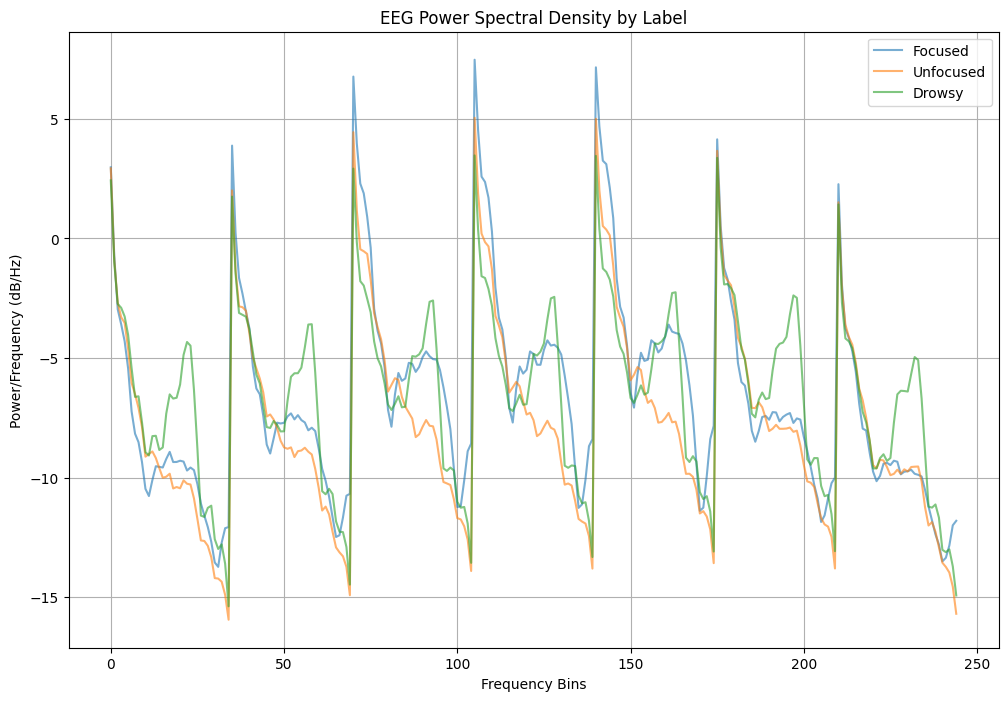

In [ ]:
def plot_psd_binned_with_labels(processed_data, label_data):
    """
    Plot the Power Spectral Density (PSD) for each label (Focused, Unfocused, Drowsy).

    Args:
        processed_data: Data containing the features for each time point.
        label_data: Data containing the labels for each time point.
    """
    # Taking labels as numpy array
    labels = label_data.to_numpy()

    # Number of frequency bins
    num_bins = processed_data.shape[1] - 1  # Trừ cột 'Label'

    # Create separate DataFrames for each label
    focused_data = processed_data[labels == 0].drop(columns=["Label"])
    unfocused_data = processed_data[labels == 1].drop(columns=["Label"])
    drowsy_data = processed_data[labels == 2].drop(columns=["Label"])

    # Calculate the mean PSD for each label
    psd_focused = focused_data.mean(axis=0)
    psd_unfocused = unfocused_data.mean(axis=0)
    psd_drowsy = drowsy_data.mean(axis=0)

    # Plot PSD for each label
    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(num_bins), psd_focused, label="Focused", alpha=0.6)
    plt.plot(np.arange(num_bins), psd_unfocused, label="Unfocused", alpha=0.6)
    plt.plot(np.arange(num_bins), psd_drowsy, label="Drowsy", alpha=0.6)

    # Naming for plot
    plt.title("EEG Power Spectral Density by Label")
    plt.xlabel("Frequency Bins")
    plt.ylabel("Power/Frequency (dB/Hz)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_psd_binned_with_labels(
    subject3_preprocessed_data, subject3_preprocessed_data["Label"]
)

In [ ]:
def plot_frequency_band_activity(data, channel=1, bands=None, labels=None):
    """
    Plot average power for predefined frequency bands with dashed lines for label transitions.

    Args:
        data (pd.DataFrame): Preprocessed EEG data.
        channel (int): EEG channel to visualize (default: 1).
        bands (dict): Frequency bands (default: Delta, Theta, Alpha, Beta).
        labels (pd.Series): Series of labels sorted by time to indicate transitions.

    Returns:
        None
    """
    # Define frequency bands if not provided
    if bands is None:
        bands = {"Delta": (0.5, 4), "Theta": (4, 8), "Alpha": (8, 13), "Beta": (13, 18)}

    # Extract columns for the given channel
    channel_columns = [
        col for col in data.columns if col.startswith(f"Channel_{channel}_Freq")
    ]
    power_spectrum = data[channel_columns].to_numpy()

    # Map frequency bins to bands
    avg_band_power = {}
    freq_bins = np.linspace(0.5, 18, len(channel_columns) + 1)
    for band_name, (low, high) in bands.items():
        band_mask = (freq_bins[:-1] >= low) & (freq_bins[:-1] < high)
        avg_band_power[band_name] = np.mean(power_spectrum[:, band_mask], axis=1)

    # Plot frequency bands
    plt.figure(figsize=(12, 6))
    for band_name, band_power in avg_band_power.items():
        plt.plot(
            np.arange(len(band_power)),
            band_power,
            label=band_name,
            alpha=0.7,
        )

    # Add dashed lines for label transitions
    if labels is not None:
        # Identify transition points based on sorted label changes
        label_changes = (
            labels.ne(labels.shift()).to_numpy().nonzero()[0][1:]
        )  # Exclude first change
        for change in label_changes:
            plt.axvline(
                change, color="black", linestyle="--", alpha=0.8, label="nolegend"
            )

    # Add labels and legend
    plt.title(f"Frequency Band Activity Over Time for Channel {channel}")
    plt.xlabel("Time Window")
    plt.ylabel("Power (dB)")
    plt.legend()
    plt.show()
    

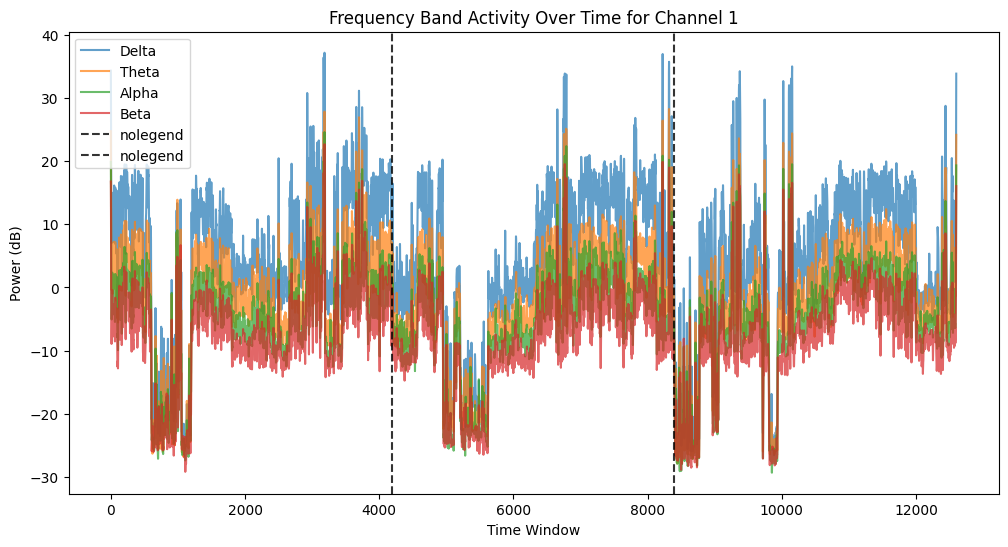

In [16]:
labels = pd.Series([0] * 4193 + [1] * 4200 + [2] * 4207)
plot_frequency_band_activity(subject1_preprocessed_data, labels=labels)

# Model Development

In [140]:
def train_and_evaluate_svm(preprocessed_data, label_column="Label"):
    """
    Train and evaluate a standard SVM classifier.

    Args:
        preprocessed_data (pd.DataFrame): Preprocessed EEG data with features and labels.
        label_column (str): Name of the column containing labels.

    Returns:
        None: Prints the classification report.
    """
    # Separate features and labels
    features = preprocessed_data.drop(columns=[label_column]).values
    labels = preprocessed_data[label_column].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42
    )

    # Initialize LabelBinarizer for multiclass AUC calculation
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)

    # Train the SVM
    svm = SVC(kernel="rbf", C=1, probability=True, random_state=42)
    svm.fit(X_train, y_train)

    # Evaluate the SVM
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate roc_auc_score for multi-class classification
    y_pred_proba = svm.predict_proba(X_test)
    auc_value = roc_auc_score(
        y_test_binarized, y_pred_proba, average="macro", multi_class="ovr"
    )

    # Print classification report
    print("Classification Report for SVM:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {auc_value:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # ROC Curve (Multi-class version using OvR)
    fpr = dict()
    tpr = dict()
    roc_aucs = dict()

    n_classes = y_test_binarized.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_aucs[i] = auc(fpr[i], tpr[i])  # Calculate AUC for each class

    # Plot ROC Curve
    plt.figure(figsize=(4, 3))
    for i in range(n_classes):
        plt.plot(
            fpr[i], tpr[i], label=f"Class {lb.classes_[i]} (AUC = {roc_aucs[i]:.2f})"
        )

    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve (One-vs-Rest)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    return accuracy, auc_value


def train_and_evaluate_xgboost(preprocessed_data, label_column="Label"):
    """
    Train and evaluate an XGBoost classifier with MinMax scaling for features, calculate ROC AUC score,
    and display feature importance (Top 10 features).

    Args:
        preprocessed_data (pd.DataFrame): Preprocessed EEG data with features and labels.
        label_column (str): Name of the column containing labels.

    Returns:
        accuracy (float): Accuracy score for the model.
        roc_auc (float): ROC AUC score for the model.
    """
    # Separate features and labels
    features = preprocessed_data.drop(columns=[label_column])
    labels = preprocessed_data[label_column]

    # Store the original feature names
    feature_names = features.columns

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, labels, test_size=0.2, random_state=42
    )

    # Initialize and train the XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        objective="multi:softmax",  # Multiclass classification
        num_class=len(set(labels)),  # Number of classes
        eval_metric="mlogloss",  # Log loss metric
        use_label_encoder=False,  # Avoid label encoder warning
        random_state=42,
        verbosity=0,  # Suppress verbosity during training
    )
    xgb_model.fit(X_train, y_train)

    # Binarize the labels for ROC AUC calculation
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)

    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    print("Classification Report for XGBoost:")
    print(classification_report(y_test, y_pred))

    # Calculate ROC AUC score for multi-class classification
    y_pred_proba = xgb_model.predict_proba(X_test)

    # Calculate ROC AUC score using the one-vs-rest approach
    roc_auc_value = roc_auc_score(
        y_test_binarized, y_pred_proba, average="macro", multi_class="ovr"
    )
    accuracy = xgb_model.score(X_test, y_test)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc_value:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot ROC Curve (One-vs-Rest)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = y_test_binarized.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curve for all classes
    plt.figure(figsize=(4, 3))
    for i in range(n_classes):
        plt.plot(
            fpr[i], tpr[i], label=f"Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})"
        )

    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve (One-vs-Rest)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # Feature importance
    feature_importance = xgb_model.feature_importances_

    # Create a DataFrame with feature names and their importance
    feature_df = pd.DataFrame(
        {"Feature": feature_names, "Importance": feature_importance}
    )

    # Sort the features by importance in descending order
    feature_df = feature_df.sort_values(by="Importance", ascending=False)

    # Display top 3 features by importance
    print("\nTop 3 Features by Importance:")
    print(feature_df.head(3))

    return accuracy, roc_auc_value


def train_and_evaluate_random_forest(preprocessed_data, label_column="Label"):
    """
    Train and evaluate a Random Forest classifier.

    Args:
        preprocessed_data (pd.DataFrame): Preprocessed EEG data with features and labels.
        label_column (str): Name of the column containing labels.

    Returns:
        None: Prints the classification report.
    """
    # Separate features and labels
    features = preprocessed_data.drop(columns=[label_column]).values
    labels = preprocessed_data[label_column].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42
    )

    # Initialize and train the Random Forest classifier
    rf_model = RandomForestClassifier(
        n_estimators=100,  # Number of trees in the forest
        max_depth=None,  # Maximum depth of the tree
        random_state=42,  # For reproducibility
        class_weight="balanced",  # Handles imbalanced data
    )
    rf_model.fit(X_train, y_train)

    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    y_pred_proba = rf_model.predict_proba(X_test)
    auc_value = roc_auc_score(
        y_test_binarized, y_pred_proba, average="macro", multi_class="ovr"
    )

    print("Classification Report for Random Forest:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {auc_value:.4f}")
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # ROC Curve (Multi-class version using OvR)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = y_test_binarized.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curve
    plt.figure(figsize=(4, 3))
    for i in range(n_classes):
        plt.plot(
            fpr[i], tpr[i], label=f"Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})"
        )

    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve (One-vs-Rest)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    return accuracy, auc_value

# Apply model

In [141]:
# Function to compare models' accuracy and AUC across subjects
def compare_models_across_subjects(subjects_data):
    """
    Compare the accuracy and AUC of SVM, XGBoost, and Random Forest models across all subjects.
    """
    # Store the metrics for all models across all subjects
    metrics = {
        "SVM": {"accuracy": [], "auc": []},
        "XGBoost": {"accuracy": [], "auc": []},
        "RandomForest": {"accuracy": [], "auc": []},
    }

    for i, subject_data in enumerate(subjects_data, start=1):
        print(f"--------Evaluating Subject {i}-------")

        # SVM evaluation
        svm_accuracy, svm_auc = train_and_evaluate_svm(preprocessed_data=subject_data)
        metrics["SVM"]["accuracy"].append(svm_accuracy)
        metrics["SVM"]["auc"].append(svm_auc)

        # XGBoost evaluation
        xgb_accuracy, xgb_auc = train_and_evaluate_xgboost(
            preprocessed_data=subject_data
        )
        metrics["XGBoost"]["accuracy"].append(xgb_accuracy)
        metrics["XGBoost"]["auc"].append(xgb_auc)

        # Random Forest evaluation
        rf_accuracy, rf_auc = train_and_evaluate_random_forest(
            preprocessed_data=subject_data
        )
        metrics["RandomForest"]["accuracy"].append(rf_accuracy)
        metrics["RandomForest"]["auc"].append(rf_auc)

    # Plotting the results
    labels = ["Subject 1", "Subject 2", "Subject 3", "Subject 4", "Subject 5"]

    # Create subplots for accuracy and AUC
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Accuracy
    axes[0].plot(labels, metrics["SVM"]["accuracy"], label="SVM", marker="o")
    axes[0].plot(labels, metrics["XGBoost"]["accuracy"], label="XGBoost", marker="o")
    axes[0].plot(
        labels, metrics["RandomForest"]["accuracy"], label="RandomForest", marker="o"
    )
    axes[0].set_title("Accuracy Across Subjects")
    axes[0].set_xlabel("Subjects")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    # Plot AUC
    axes[1].plot(labels, metrics["SVM"]["auc"], label="SVM", marker="o")
    axes[1].plot(labels, metrics["XGBoost"]["auc"], label="XGBoost", marker="o")
    axes[1].plot(
        labels, metrics["RandomForest"]["auc"], label="RandomForest", marker="o"
    )
    axes[1].set_title("AUC Across Subjects")
    axes[1].set_xlabel("Subjects")
    axes[1].set_ylabel("AUC")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Train with Each Subject

--------Evaluating Subject 1-------
Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       854
         1.0       0.97      0.98      0.97       854
         2.0       0.98      0.97      0.97       812

    accuracy                           0.98      2520
   macro avg       0.98      0.98      0.98      2520
weighted avg       0.98      0.98      0.98      2520

Accuracy: 0.9813
ROC AUC Score: 0.9981

Confusion Matrix:
[[854   0   0]
 [  5 834  15]
 [  4  23 785]]


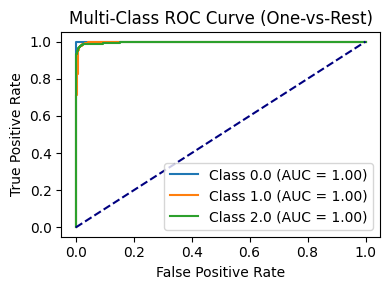

Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       854
         1.0       0.99      1.00      0.99       854
         2.0       1.00      0.98      0.99       812

    accuracy                           0.99      2520
   macro avg       0.99      0.99      0.99      2520
weighted avg       0.99      0.99      0.99      2520

Accuracy: 0.9944
ROC AUC Score: 0.9997

Confusion Matrix:
[[854   0   0]
 [  0 853   1]
 [  1  12 799]]


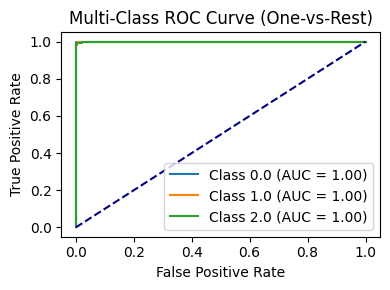


Top 3 Features by Importance:
                        Feature  Importance
166  Channel_5_Freq_13.5-14.0Hz    0.059487
130  Channel_4_Freq_13.0-13.5Hz    0.058267
113    Channel_4_Freq_4.5-5.0Hz    0.038955
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       854
         1.0       0.98      0.99      0.99       854
         2.0       0.99      0.97      0.98       812

    accuracy                           0.99      2520
   macro avg       0.99      0.99      0.99      2520
weighted avg       0.99      0.99      0.99      2520

Accuracy: 0.9889
ROC AUC Score: 0.9996

Confusion Matrix:
[[854   0   0]
 [  3 847   4]
 [  3  18 791]]


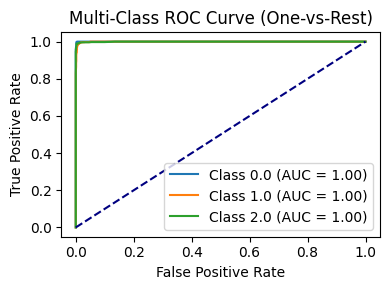

--------Evaluating Subject 2-------
Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       854
         1.0       0.97      0.97      0.97       854
         2.0       0.98      0.98      0.98       812

    accuracy                           0.98      2520
   macro avg       0.98      0.98      0.98      2520
weighted avg       0.98      0.98      0.98      2520

Accuracy: 0.9774
ROC AUC Score: 0.9983

Confusion Matrix:
[[843   8   3]
 [ 15 828  11]
 [  4  16 792]]


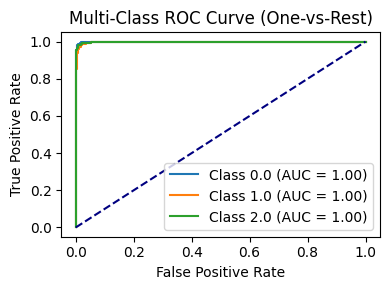

Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       854
         1.0       0.99      0.99      0.99       854
         2.0       0.99      0.99      0.99       812

    accuracy                           0.99      2520
   macro avg       0.99      0.99      0.99      2520
weighted avg       0.99      0.99      0.99      2520

Accuracy: 0.9921
ROC AUC Score: 0.9999

Confusion Matrix:
[[847   2   5]
 [  3 847   4]
 [  2   4 806]]


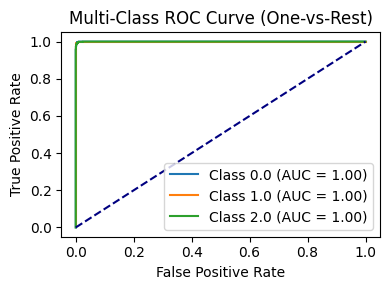


Top 3 Features by Importance:
                        Feature  Importance
232  Channel_7_Freq_11.5-12.0Hz    0.069511
162  Channel_5_Freq_11.5-12.0Hz    0.035997
174  Channel_5_Freq_17.5-18.0Hz    0.034534
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       854
         1.0       0.97      0.98      0.97       854
         2.0       0.98      0.97      0.98       812

    accuracy                           0.98      2520
   macro avg       0.98      0.98      0.98      2520
weighted avg       0.98      0.98      0.98      2520

Accuracy: 0.9778
ROC AUC Score: 0.9987

Confusion Matrix:
[[842   7   5]
 [  9 833  12]
 [  4  19 789]]


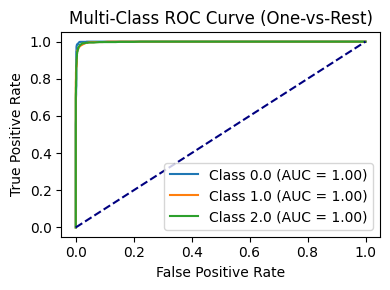

--------Evaluating Subject 3-------
Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       854
         1.0       0.95      0.99      0.97       854
         2.0       0.99      0.95      0.97       812

    accuracy                           0.98      2520
   macro avg       0.98      0.98      0.98      2520
weighted avg       0.98      0.98      0.98      2520

Accuracy: 0.9786
ROC AUC Score: 0.9979

Confusion Matrix:
[[852   0   2]
 [  2 846   6]
 [  3  41 768]]


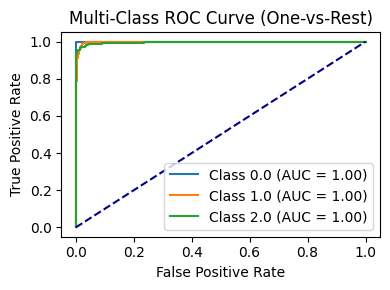

Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       854
         1.0       0.98      0.99      0.99       854
         2.0       0.99      0.98      0.99       812

    accuracy                           0.99      2520
   macro avg       0.99      0.99      0.99      2520
weighted avg       0.99      0.99      0.99      2520

Accuracy: 0.9901
ROC AUC Score: 0.9997

Confusion Matrix:
[[850   2   2]
 [  1 848   5]
 [  3  12 797]]


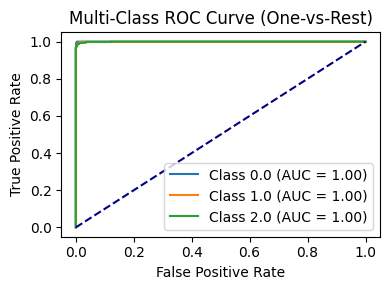


Top 3 Features by Importance:
                        Feature  Importance
174  Channel_5_Freq_17.5-18.0Hz    0.064485
21   Channel_1_Freq_11.0-11.5Hz    0.048238
161  Channel_5_Freq_11.0-11.5Hz    0.034502
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       854
         1.0       0.95      0.99      0.97       854
         2.0       0.99      0.93      0.96       812

    accuracy                           0.97      2520
   macro avg       0.97      0.97      0.97      2520
weighted avg       0.97      0.97      0.97      2520

Accuracy: 0.9722
ROC AUC Score: 0.9980

Confusion Matrix:
[[850   2   2]
 [  5 842   7]
 [  7  47 758]]


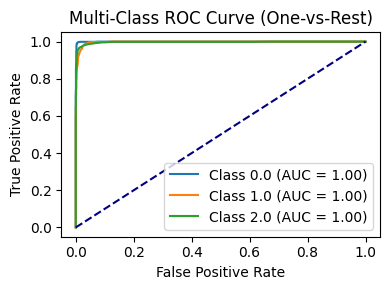

--------Evaluating Subject 4-------
Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       852
         1.0       1.00      0.99      0.99       850
         2.0       1.00      0.99      0.99       794

    accuracy                           0.99      2496
   macro avg       0.99      0.99      0.99      2496
weighted avg       0.99      0.99      0.99      2496

Accuracy: 0.9948
ROC AUC Score: 1.0000

Confusion Matrix:
[[852   0   0]
 [  5 844   1]
 [  4   3 787]]


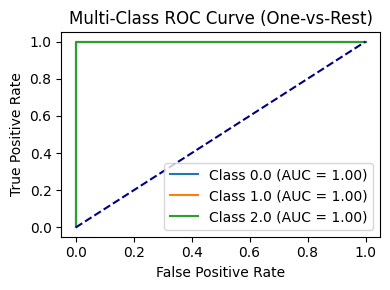

Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       852
         1.0       1.00      1.00      1.00       850
         2.0       1.00      0.99      1.00       794

    accuracy                           1.00      2496
   macro avg       1.00      1.00      1.00      2496
weighted avg       1.00      1.00      1.00      2496

Accuracy: 0.9984
ROC AUC Score: 1.0000

Confusion Matrix:
[[852   0   0]
 [  0 850   0]
 [  4   0 790]]


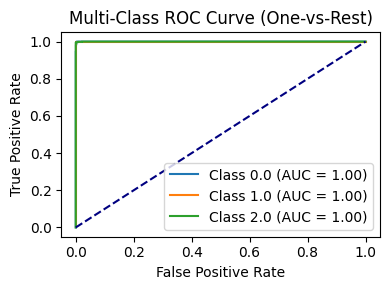


Top 3 Features by Importance:
                      Feature  Importance
77   Channel_3_Freq_4.0-4.5Hz    0.038720
18  Channel_1_Freq_9.5-10.0Hz    0.034208
46   Channel_2_Freq_6.0-6.5Hz    0.022804
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       852
         1.0       1.00      0.99      0.99       850
         2.0       1.00      0.99      1.00       794

    accuracy                           0.99      2496
   macro avg       0.99      0.99      0.99      2496
weighted avg       0.99      0.99      0.99      2496

Accuracy: 0.9940
ROC AUC Score: 0.9998

Confusion Matrix:
[[852   0   0]
 [  9 841   0]
 [  6   0 788]]


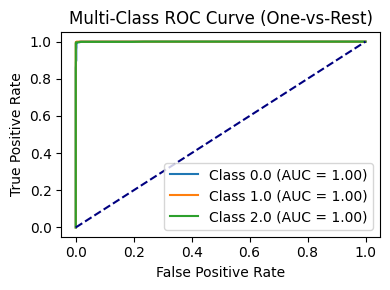

--------Evaluating Subject 5-------
Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       707
         1.0       0.95      0.97      0.96       716
         2.0       0.99      0.95      0.97       737

    accuracy                           0.97      2160
   macro avg       0.97      0.97      0.97      2160
weighted avg       0.97      0.97      0.97      2160

Accuracy: 0.9685
ROC AUC Score: 0.9971

Confusion Matrix:
[[694  12   1]
 [ 15 696   5]
 [ 10  25 702]]


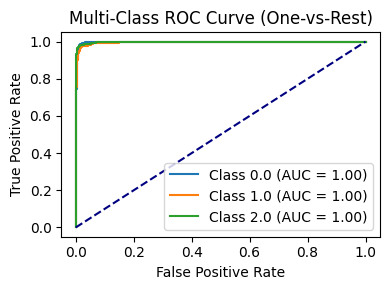

Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       707
         1.0       0.99      1.00      0.99       716
         2.0       1.00      0.98      0.99       737

    accuracy                           0.99      2160
   macro avg       0.99      0.99      0.99      2160
weighted avg       0.99      0.99      0.99      2160

Accuracy: 0.9912
ROC AUC Score: 0.9992

Confusion Matrix:
[[703   1   3]
 [  3 713   0]
 [  4   8 725]]


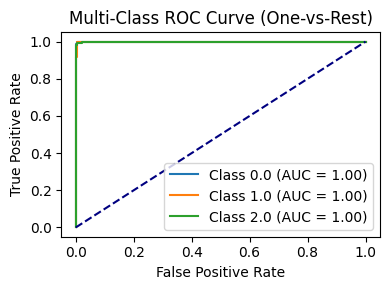


Top 3 Features by Importance:
                      Feature  Importance
15   Channel_1_Freq_8.0-8.5Hz    0.084509
109  Channel_4_Freq_2.5-3.0Hz    0.036791
116  Channel_4_Freq_6.0-6.5Hz    0.032375
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       707
         1.0       0.97      0.96      0.97       716
         2.0       0.98      0.97      0.98       737

    accuracy                           0.97      2160
   macro avg       0.97      0.97      0.97      2160
weighted avg       0.97      0.97      0.97      2160

Accuracy: 0.9727
ROC AUC Score: 0.9978

Confusion Matrix:
[[696   4   7]
 [ 20 690   6]
 [  8  14 715]]


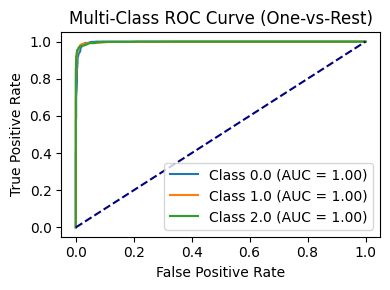

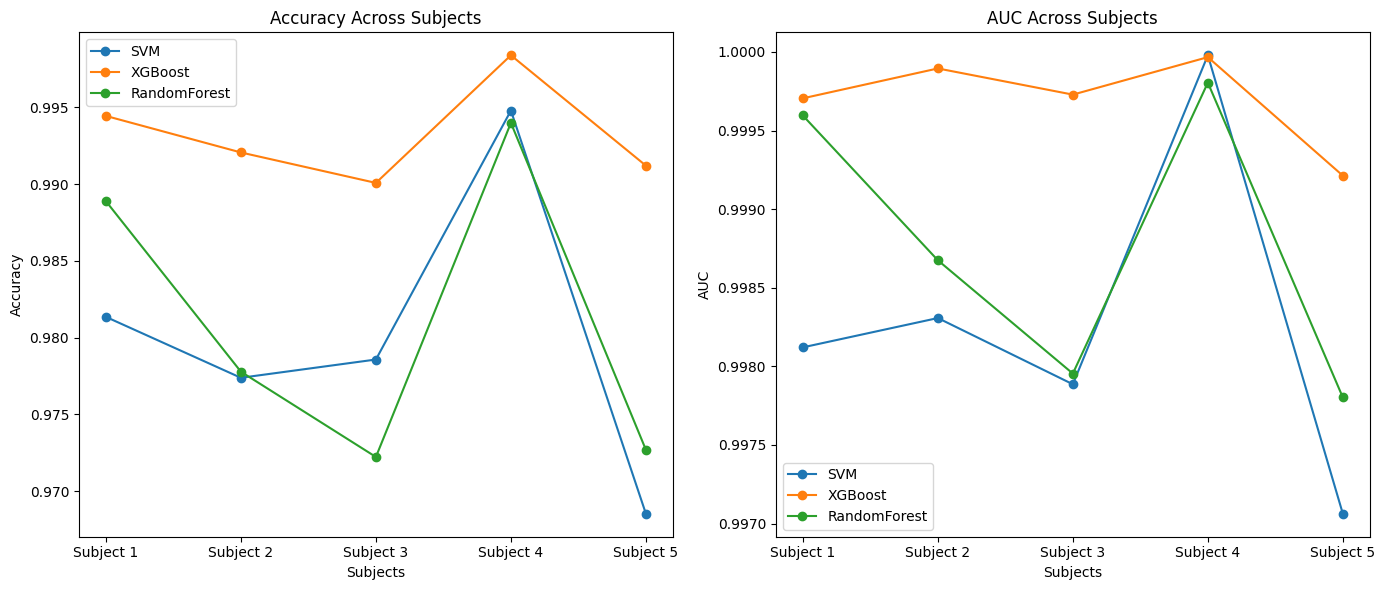

In [142]:
subjects_data = [
    subject1_preprocessed_data,
    subject2_preprocessed_data,
    subject3_preprocessed_data,
    subject4_preprocessed_data,
    subject5_preprocessed_data,
]

compare_models_across_subjects(subjects_data=subjects_data)

# Evaluate The Result

### 1. Hiệu suất chung của các mô hình:
- Nhìn chung, kết quả dự đoán và phân loại của các mô hình đều rất tốt. Tất cả các mô hình đều đạt các chỉ số metric (accuracy, AUC, precision, recall) lớn hơn 0.9 đối với tất cả 5 đối tượng (subjects. Các chỉ số này là minh chứng khá tích cực cho khả năng của các mô hình trong việc phân loại các mẫu dữ liệu phức tạp từ EEG trong project này.

### 2. Mô hình XGBoost:
- XGBoost luôn đạt các chỉ số metric cao nhất trong ba mô hình, gồm accuracy và AUC. Việc XGBoost có hiệu suất cao nhất là hợp lý, bởi vì XGBoost là một mô hình cây quyết định sử dụng các kỹ thuật boosting để giảm thiểu bias và variance, đồng thời có tính năng tự động điều chỉnh trọng số các mẫu imbalance. Điều này giúp model có thể làm việc tốt với các tập dữ liệu lớn và nhiều đặc trưng (mẫu có cấu trúc phức tạp và lớn), lý giải vì sao XGBoost có thể đạt được độ chính xác ổn định và cao hơn so với các mô hình còn lại.
  
- Tuy nhiên, đối với một số subject, đặc biệt là subject 5, mô hình này có thể gặp phải vấn đề giảm hiệu suất, có thể là do tính chất phức tạp của dữ liệu của đối tượng đó.

### 3. Mô hình SVM:
- SVM có hiệu suất thấp nhất trong ba mô hình, với độ chính xác thấp nhất đạt 0.92 ở subject 1. Điều này có thể giải thích bởi SVM hoạt động hiệu quả nhất khi làm việc với dữ liệu nhỏ và ít chiều. SVM thường gặp khó khăn khi xử lý các dữ liệu có độ phức tạp cao hoặc số lượng mẫu lớn, đặc biệt là trong các bài toán phân loại nhiều lớp như thế này. 
  
- Khi SVM áp dụng kernel RBF (Radial Basis Function), mô hình có thể gặp khó khăn khi không có đủ dữ liệu huấn luyện để học được decision boundaries phù hợp, dẫn đến việc suy giảm hiệu suất. Nên khi áp dụng vào tập dữ liệu EEG phức tạp và nhiều chiều, mô hình này có thể không tận dụng hết được thông tin từ các đặc trưng.

### 4. Mô hình Random Forest:
- Random Forest cho thấy một hiệu suất ổn định, với kết quả accuracy và AUC khá ổn định giữa các subject. Mô hình này có khả năng giảm thiểu overfitting thông qua việc sử dụng nhiều cây quyết định và các kỹ thuật randomization, do đó Random Forest có thể duy trì một mức độ chính xác nhất định trong các tình huống khác nhau. Đồng thời hoạt động tốt trong những tình huống dữ liệu bị mất mát hoặc thiếu thông tin.
  
- Tuy nhiên, Random Forest vẫn không đạt được độ chính xác cao như XGBoost trong hầu hết các trường hợp, có thể là do khả năng của Random Forest trong việc học các tương quan phức tạp và tính toán các quyết định không được tối ưu như XGBoost.

### 5. Sự thay đổi giữa các subject:
- Có thể thấy rằng accuracy giữa các mô hình thay đổi theo xu hướng giống nhau: cả SVM và XGBoost đều tăng dần từ subject 1 đến subject 4, và giảm ở subject 5. Trong khi đó AUC của các mô hình SVM và Random Forest có xu hướng tương tự nhau
- Nhìn vào sự biến đổi của các chỉ số có thể thấy sự thay đổi trong tính chất của dữ liệu EEG giữa các đối tượng. Các subject đầu tiên có thể có dữ liệu ít phức tạp và dễ phân loại hơn, trong khi subject 5 có thể có các mẫu EEG khó phân loại hoặc có nhiễu cao, làm giảm hiệu suất của các mô hình.

# Traing on All Data

In [143]:
subject1_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_1"]
)
subject2_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_2"]
)
subject3_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_3"]
)
subject4_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_4"]
)
subject5_data = load_subject_data(
    Data_root=data_root, Subject_files=subject_file_map["subject_5"]
)

dataframes = [subject1_data, subject2_data, subject3_data, subject4_data, subject5_data]

combined_data = pd.concat(dataframes, ignore_index=True)
combined_data = combined_data.sort_values(by="Label").reset_index(drop=True)

preprocessed_data = feature_engineering_eegdata_with_labels(eeg_data=combined_data)

# Shape before dropping NaN values
print(preprocessed_data.shape)
preprocessed_data = preprocessed_data.dropna(subset=["Label"])
# Shape after dropping NaN values
print(preprocessed_data.shape)

Loaded eeg_record1.mat with shape (230400, 8)
Loaded eeg_record2.mat with shape (230400, 8)
Loaded eeg_record3.mat with shape (230400, 8)
Loaded eeg_record4.mat with shape (230400, 8)
Loaded eeg_record5.mat with shape (230400, 8)
Loaded eeg_record6.mat with shape (230400, 8)
Loaded eeg_record7.mat with shape (230400, 8)
Loaded eeg_record8.mat with shape (230400, 8)
Loaded eeg_record9.mat with shape (230400, 8)
Loaded eeg_record10.mat with shape (230400, 8)
Loaded eeg_record11.mat with shape (230400, 8)
Loaded eeg_record12.mat with shape (230400, 8)
Loaded eeg_record13.mat with shape (230400, 8)
Loaded eeg_record14.mat with shape (230400, 8)
Loaded eeg_record15.mat with shape (230400, 8)
Loaded eeg_record16.mat with shape (230400, 8)
Loaded eeg_record17.mat with shape (230400, 8)
Loaded eeg_record18.mat with shape (230400, 8)
Loaded eeg_record19.mat with shape (230400, 8)
Loaded eeg_record20.mat with shape (230400, 8)
Loaded eeg_record21.mat with shape (230400, 8)
Loaded eeg_record22.ma

Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4058
         1.0       0.92      0.96      0.94      4025
         2.0       0.97      0.94      0.96      4133

    accuracy                           0.95     12216
   macro avg       0.96      0.95      0.95     12216
weighted avg       0.96      0.95      0.95     12216

Accuracy: 0.9546
ROC AUC Score: 0.9946

Confusion Matrix:
[[3924  120   14]
 [  85 3850   90]
 [  33  212 3888]]


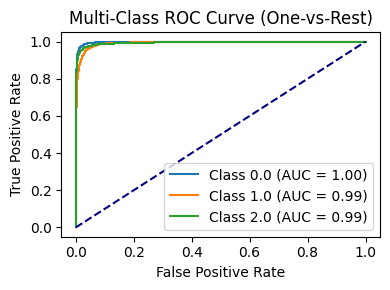

Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      4058
         1.0       0.95      0.98      0.97      4025
         2.0       0.99      0.97      0.98      4133

    accuracy                           0.98     12216
   macro avg       0.98      0.98      0.98     12216
weighted avg       0.98      0.98      0.98     12216

Accuracy: 0.9755
ROC AUC Score: 0.9986

Confusion Matrix:
[[3962   82   14]
 [  41 3945   39]
 [  15  108 4010]]


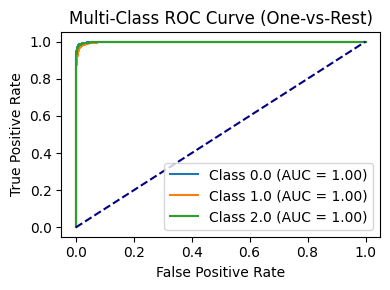


Top 3 Features by Importance:
                       Feature  Importance
108   Channel_4_Freq_2.0-2.5Hz    0.046683
142   Channel_5_Freq_1.5-2.0Hz    0.021594
228  Channel_7_Freq_9.5-10.0Hz    0.020520
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4058
         1.0       0.96      0.98      0.97      4025
         2.0       0.99      0.96      0.98      4133

    accuracy                           0.97     12216
   macro avg       0.98      0.98      0.97     12216
weighted avg       0.98      0.97      0.97     12216

Accuracy: 0.9750
ROC AUC Score: 0.9985

Confusion Matrix:
[[3988   53   17]
 [  56 3934   35]
 [  17  128 3988]]


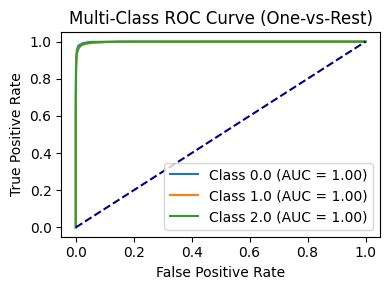

(0.974950884086444, np.float64(0.9984714499893917))

In [144]:
# Train and evaluate on model
train_and_evaluate_svm(preprocessed_data)
train_and_evaluate_xgboost(preprocessed_data)
train_and_evaluate_random_forest(preprocessed_data)

# Evaluate Results

### 1. Mô hình SVM:
- Accuracy: 87.2%, AUC: 0.9659 
- Mô hình SVM đạt độ chính xác tốt nhưng thấp hơn so với XGBoost và Random Forest. AUC cao cho thấy khả năng phân biệt lớp tốt nhưng cũng tương tự như khi thực hiện trên tập các subject thì mô hình này vẫn là mô hình có các chỉ số metric thấp nhất.

### 2. Mô hình XGBoost:
- Accuracy: 92.5%, AUC: 0.9864
- Mô hình XGBoost có hiệu suất vượt trội với độ chính xác và AUC cao. Các chỉ số precision, recall và f1-score đều rất tốt, đặc biệt là với state drowsy.

### 3. Mô hình RandomForest:
- Accuracy: 94.7%, AUC: 0.993
- Mô hình RandomForest có hiệu suất cao với độ chính xác và AUC cao. Khác hẳn với việc thực hiện trên từng subject thì trên tập tất cả dữ liệu, mô hình RandomForest có các chỉ số metric cao nhất trong 3 model.

# Testing with Neural Network:
Xử lý dữ liệu EEG, huấn luyện, kiểm tra và đánh giá mô hình mạng nơ-ron để phân loại trạng thái chú ý (e.g., Focused, Unfocused, Drowsy) bằng cách sử dụng một quy trình học sâu có cấu trúc.


## Preprocessing Pipeline

### Mục tiêu:
Chuẩn bị tín hiệu EEG thô để huấn luyện bằng cách phân đoạn (segmenting), chuẩn hóa (normalizing) và gán nhãn (labeling).

### Các bước

1. *Data Loading*:
   - Trích xuất tín hiệu EEG và các kênh liên quan từ các tệp .mat.
   - Giữ lại các cột cần thiết (các kênh EEG cụ thể).

2. *Segmentation*:
   - Chia tín hiệu EEG thành các overlapping windows dựa trên window_size và step_size được xác định trước.
   - Đảm bảo trích xuất đặc trưng hiệu quả trong khi tối đa hóa số lượng mẫu huấn luyện.

3. *Label Assignment*:
   - Gán label cho mỗi đoạn tín hiệu dựa trên label phổ biến nhất hoặc label có giá trị cao nhất trong cửa sổ.

4. *Normalization*:
   - Chuẩn hóa từng đoạn tín hiệu về giá trị trung bình bằng 0 và phương sai đơn vị để đảm bảo tính nhất quán về thang đo giữa các đặc trưng.

### Kết quả:
- Dữ liệu EEG đã được phân đoạn và chuẩn hóa sẵn sàng làm input cho mô hình.
- Label tương ứng cho mỗi đoạn tín hiệu.

### Key Features
- Các *overlapping window* tăng cường sự đa dạng mẫu.
- *Chuẩn hóa* từng đoạn giúp giảm ảnh hưởng từ biên độ tín hiệu khác nhau.
- *Labeling* đảm bảo sự liên kết giữa các đoạn EEG theo trạng thái chú ý.

In [ ]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import numpy as np
import pandas as pd
import os
import scipy.io

import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import stft
from scipy.ndimage import uniform_filter1d
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def preprocess_eeg_data(eeg_data, window_size, step_size, sampling_freq):
    """
    Preprocess EEG data: segment, normalize, and prepare for CNN.

    Args:
        eeg_data (pd.DataFrame): EEG data with time samples as rows and labels included.
        window_size (int): Window size in seconds.
        step_size (int): Step size for overlapping windows in seconds.
        sampling_freq (int): Sampling frequency (Hz).

    Returns:
        np.ndarray: Preprocessed data segments (samples x channels x time points).
        np.ndarray: Labels corresponding to each segment.
    """
    # Extract labels and EEG signals
    labels = eeg_data["Label"].values
    eeg_signals = eeg_data.drop(columns=["Label"]).to_numpy()

    # Define window size and step size in samples
    window_samples = int(window_size * sampling_freq)
    step_samples = int(step_size * sampling_freq)

    segments = []
    segment_labels = []

    # Create segments
    for start in range(0, eeg_signals.shape[0] - window_samples + 1, step_samples):
        segment = eeg_signals[start : start + window_samples].T
        label = labels[start : start + window_samples].max()
        segments.append(segment)
        segment_labels.append(label)

    # Convert to numpy arrays
    segments = np.array(segments, dtype=np.float32)
    segment_labels = np.array(segment_labels, dtype=np.int64)

    # Normalize each segment
    segments = (segments - np.mean(segments, axis=-1, keepdims=True)) / (
        np.std(segments, axis=-1, keepdims=True) + 1e-8
    )

    return segments, segment_labels

In [ ]:
def load_subject_data(subject_files, data_root, sampling_rate=128):
    """
    Load EEG data for a specific subject from multiple .mat files.

    Args:
        subject_files (list): List of .mat filenames for the subject.
        data_root (str): Path to the directory containing .mat files.
        sampling_rate (int): Sampling frequency (Hz).

    Returns:
        pd.DataFrame: Combined EEG data with time-based labels for the subject.
    """
    subject_data = []

    for filename in subject_files:
        filepath = os.path.join(data_root, filename)
        mat = scipy.io.loadmat(filepath)
        data = pd.DataFrame.from_dict(mat["o"]["data"][0, 0])

        # Process data
        dat = data.filter(list(range(3, 17)))
        dat.columns = list(range(1, 15))
        dat = dat.filter([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], axis=1)

        labels = [
            "AF3",
            "F7",
            "F3",
            "FC5",
            "T7",
            "P7",
            "O1",
            "O2",
            "P8",
            "T8",
            "FC6",
            "F4",
            "F8",
            "AF4",
        ]
        dat.columns = labels

        # Add time-based labels
        num_rows = dat.shape[0]
        focus_end = int(10 * 60 * sampling_rate)  # 0–10 min
        unfocus_end = int(20 * 60 * sampling_rate)  # 10–20 min
        drowsy_end = int(40 * 60 * sampling_rate)  # 20–40 min

        labels_column = []
        for i in range(num_rows):
            if i < focus_end:
                labels_column.append(0)  # Focus
            elif i < unfocus_end:
                labels_column.append(1)  # Unfocused
            else:
                labels_column.append(2)  # Drowsy

        dat = dat.iloc[: len(labels_column)]  # Ensure data aligns with labels
        dat["Label"] = labels_column

        subject_data.append(dat)

    return pd.concat(subject_data, ignore_index=True)

## Training and Cross-Validation

### Mục tiêu:
Đảm bảo đánh giá mô hình toàn diện và tối ưu hóa hiệu suất thông qua cross-validation và kiểm tra trên tập validation.

### Các bước

1. *Cross-Validation Setup*:
   - Thực hiện đánh giá chéo k-fold (e.g., 5-fold) để chia dữ liệu thành tập train và tập test.
   - Tập train được chia nhỏ thành các tập train và tập validation.

2. *Weighted Sampling*:
   - Xử lý class imbalance bằng cách sử dụng WeightedRandomSampler để gán trọng số cao hơn cho các lớp ít xuất hiện.

3. *Training*:
   - Sử dụng tập train để cập nhật tham số mô hình thông qua backpropagation.
   - Tối ưu hàm mất mát bằng optimizer Adam và CrossEntropy loss.

4. *Validation*:
   - Đánh giá mô hình trên tập validation sau mỗi epoch để theo dõi hiện tượng overfitting và khả năng khái quát hóa của mô hình.

5. *Early Stopping*:
   - Ngừng huấn luyện nếu hàm mất mát trên tập validation không cải thiện trong một số lượng epoch được xác định trước.
   - Đảm bảo quá trình huấn luyện hiệu quả và tránh overfitting.

### Kết quả
- Mô hình được huấn luyện trên dữ liệu đã cân bằng với early stopping.
- Kết quả đánh giá trên tập validation giúp theo dõi hiệu suất.

### Key Features
- *Cross-Validation*: Đảm bảo đánh giá toàn diện trên nhiều tập dữ liệu.
- *Weighted Sampling*: Cân bằng phân phối lớp để cải thiện khả năng khái quát.
- *Validation*: Ngăn chặn overfitting bằng cách đánh giá trên dữ liệu không thấy trong quá trình huấn luyện.
- *Early Stopping*: Tiết kiệm tài nguyên tính toán trong khi đảm bảo hiệu suất tối ưu.

In [ ]:
from sklearn.model_selection import KFold, train_test_split
import numpy as np


def prepare_cross_validation_data(subject_data, n_splits=5, val_split=0.2):
    """
    Perform cross-validation with separate validation data for a specific subject's data.

    Args:
        subject_data (pd.DataFrame): EEG data with labels for a specific subject.
        n_splits (int): Number of folds for cross-validation.
        val_split (float): Proportion of the training data to use as validation data.

    Returns:
        list: A list of (train_data, val_data, test_data) tuples for each fold.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    subject_segments, subject_labels = preprocess_eeg_data(
        subject_data, window_size=15, step_size=2, sampling_freq=128
    )
    folds = []

    for train_idx, test_idx in kf.split(subject_segments):
        # Split the training data into train and validation sets
        X_train, X_test = subject_segments[train_idx], subject_segments[test_idx]
        y_train, y_test = subject_labels[train_idx], subject_labels[test_idx]

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_split, random_state=42
        )

        # Append train, validation, and test data for the fold
        train_data = (X_train, y_train)
        val_data = (X_val, y_val)
        test_data = (X_test, y_test)
        folds.append((train_data, val_data, test_data))

    return folds

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        """
        Early stopping to terminate training when validation loss doesn't improve.

        Args:
            patience (int): Number of epochs to wait for improvement.
            delta (float): Minimum change to qualify as improvement.
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

In [ ]:
def train_model_with_validation(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    early_stopping,
    device,
):
    """
    Train the model with validation and early stopping.

    Args:
        model (torch.nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        num_epochs (int): Number of training epochs.
        early_stopping (EarlyStopping): EarlyStopping object.
        device (str): Device to train the model on ("cuda" or "cpu").

    Returns:
        dict: Training and validation losses per epoch.
    """
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        training_losses.append(train_loss)

        # Validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        validation_losses.append(val_loss)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}"
        )

        # Check for early stopping
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

    # Load the best model before returning
    if early_stopping and early_stopping.best_model:
        model.load_state_dict(early_stopping.best_model)

    return {"training_losses": training_losses, "validation_losses": validation_losses}

In [ ]:
from sklearn.metrics import classification_report


def evaluate_model_with_probs(model, data_loader, device, target_names=None):
    """
    Evaluate the model and return true labels, predicted probabilities, and classification report.

    Args:
        model (torch.nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for the evaluation set.
        device (str): Device to perform evaluation on.
        target_names (list, optional): List of class names for the classification report.

    Returns:
        tuple: Predicted probabilities, true labels, and classification report as a string.
    """
    model.eval()
    y_true = []
    y_pred_prob = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass to compute probabilities
            logits = model(X_batch)
            probabilities = torch.softmax(logits, dim=1)

            y_pred_prob.extend(probabilities.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    y_pred_labels = np.argmax(
        y_pred_prob, axis=1
    )  # Convert probabilities to class labels

    # Generate classification report
    report = classification_report(
        y_true,
        y_pred_labels,
        target_names=target_names,
        zero_division=0,  # To avoid warnings for labels with no predictions
    )

    print("Classification Report:")
    print(report)

    return y_pred_prob, y_true, report

In [ ]:
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np


def train_and_evaluate_subject(
    subject,
    folds,
    model_class,
    input_channels,
    input_timepoints,
    num_epochs=20,
    device="cuda",
):
    """
    Train and evaluate the model for a specific subject using cross-validation.

    Args:
        subject (str): Subject identifier.
        folds (list): List of (train_data, val_data, test_data) tuples for cross-validation.
        model_class (torch.nn.Module): CNN model class.
        input_channels (int): Number of input channels (e.g., number of EEG channels).
        input_timepoints (int): Number of time points in the input data.
        num_epochs (int): Number of training epochs.
        device (str): Device to train the model on ("cuda" or "cpu").

    Returns:
        dict: Accuracy for each fold, true labels, and predicted probabilities.
    """
    fold_accuracies = []
    subject_results = []

    for fold_idx, (train_data, val_data, test_data) in enumerate(folds):
        print(f"Subject {subject}, Fold {fold_idx + 1}/{len(folds)}")

        # Prepare train, validation, and test data
        X_train, y_train = train_data
        X_val, y_val = val_data
        X_test, y_test = test_data

        unique, counts = np.unique(y_train, return_counts=True)
        class_counts = dict(zip(unique, counts))

        # Compute weights for each sample in the training set
        class_weights = {label: 1.0 / count for label, count in class_counts.items()}
        sample_weights = [class_weights[label] for label in y_train]

        # Create a WeightedRandomSampler for the training set
        sampler = WeightedRandomSampler(
            weights=sample_weights, num_samples=len(sample_weights), replacement=True
        )

        train_loader = DataLoader(
            TensorDataset(
                torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)
            ),
            batch_size=32,
            sampler=sampler,
        )
        val_loader = DataLoader(
            TensorDataset(
                torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)
            ),
            batch_size=32,
            shuffle=False,
        )
        test_loader = DataLoader(
            TensorDataset(
                torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)
            ),
            batch_size=32,
            shuffle=False,
        )

        # Initialize the model
        model = model_class(input_channels, input_timepoints, num_classes=3).to(device)

        # Define optimizer and criterion
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        # Train the model
        train_model_with_validation(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            num_epochs=num_epochs,
            device=device,
            early_stopping=EarlyStopping(patience=5, delta=0.01),
        )

        # Evaluate the model on the test set
        y_pred_prob, y_true, _ = evaluate_model_with_probs(model, test_loader, device)
        y_pred_labels = np.argmax(
            y_pred_prob, axis=1
        )  # Convert probabilities to labels
        accuracy = accuracy_score(y_true, y_pred_labels)
        fold_accuracies.append(accuracy)

        # Store true labels and predicted probabilities for ROC-AUC computation
        subject_results.append({"y_true": y_true, "y_pred_prob": y_pred_prob})

    avg_accuracy = np.mean(fold_accuracies)
    print(f"Subject {subject} Average Accuracy: {avg_accuracy*100:.2f}%")
    return {"fold_accuracies": subject_results, "avg_accuracy": avg_accuracy}

## Model Architecture: EEG 1D CNN

### Input Layer
- Nhận tín hiệu EEG với dạng (batch_size, input_channels, input_timepoints).

### Convolutional and Pooling Layers
- Ba convolutional layers liên tiếp với *batch normalization* và *max-pooling*.
- Trích xuất các đặc trưng không gian và thời gian từ tín hiệu EEG.

### Fully Connected Layers
- Một lớp *dense* với activation *ReLU*.
- Lớp *dropout* để giảm hiện tượng *overfitting*.
- Lớp *dense* cuối cùng với activation *softmax* để xuất xác suất phân lớp.

### Output Layer
- Xuất các xác suất cho từng lớp tương ứng với trạng thái chú ý của EEG.

### Key Features
- *Convolution Layers*: Trích xuất *local temporal dependencies* giữa các kênh.
- *Batch Normalization*: Cải thiện độ ổn định và tốc độ huấn luyện.
- *Dropout*: Giảm hiện tượng *overfitting*.
- *Softmax Activation*: Chuyển đổi giá trị logits thành xác suất.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class EEG1DCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEG1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding="same")
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding="same")
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding="same")
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(256 * (input_timepoints // 8), 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

##  Code Execution


In [ ]:
subject_file_map = {
    "subject_1": [
        "eeg_record1.mat",
        "eeg_record2.mat",
        "eeg_record3.mat",
        "eeg_record4.mat",
        "eeg_record5.mat",
        "eeg_record6.mat",
        "eeg_record7.mat",
    ],
    "subject_2": [
        "eeg_record8.mat",
        "eeg_record9.mat",
        "eeg_record10.mat",
        "eeg_record11.mat",
        "eeg_record12.mat",
        "eeg_record13.mat",
        "eeg_record14.mat",
    ],
    "subject_3": [
        "eeg_record15.mat",
        "eeg_record16.mat",
        "eeg_record17.mat",
        "eeg_record18.mat",
        "eeg_record19.mat",
        "eeg_record20.mat",
        "eeg_record21.mat",
    ],
    "subject_4": [
        "eeg_record22.mat",
        "eeg_record23.mat",
        "eeg_record24.mat",
        "eeg_record25.mat",
        "eeg_record26.mat",
        "eeg_record27.mat",
        "eeg_record28.mat",
    ],
    "subject_5": [
        "eeg_record29.mat",
        "eeg_record30.mat",
        "eeg_record31.mat",
        "eeg_record32.mat",
        "eeg_record33.mat",
        "eeg_record34.mat",
    ],
}

data_root = "./EEG Data"
results = {}

# Assuming your EEG data shape is (samples, channels, time points)
input_channels = 14  # Number of EEG channels
input_timepoints = 15 * 128  # Number of time points in each sample

# Initialize results dictionary
results = {}

for subject, files in subject_file_map.items():
    print(f"Processing {subject}...")

    # Load subject data
    subject_data = load_subject_data(files, data_root)

    # Prepare 10-fold cross-validation data
    folds = prepare_cross_validation_data(subject_data)

    # Train and evaluate
    results[subject] = train_and_evaluate_subject(
        subject,
        folds,
        EEG1DCNN,
        num_epochs=20,
        input_channels=input_channels,
        input_timepoints=input_timepoints,
        device="cuda",
    )

print("Final Results:", results)

Processing subject_1...
Subject subject_1, Fold 1/5
Epoch [1/20], Train Loss: 1.1968, Validation Loss: 0.9780
Epoch [2/20], Train Loss: 1.2143, Validation Loss: 0.9780
Epoch [3/20], Train Loss: 1.2208, Validation Loss: 1.3429
Epoch [4/20], Train Loss: 1.1918, Validation Loss: 1.3430
Epoch [5/20], Train Loss: 1.1459, Validation Loss: 1.2263
Epoch [6/20], Train Loss: 1.0161, Validation Loss: 1.0059
Early stopping triggered.
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.83      0.59       427
           1       0.37      0.37      0.37       439
           2       0.67      0.45      0.54      1048

    accuracy                           0.51      1914
   macro avg       0.50      0.55      0.50      1914
weighted avg       0.55      0.51      0.51      1914

Subject subject_1, Fold 2/5
Epoch [1/20], Train Loss: 1.2208, Validation Loss: 0.9825
Epoch [2/20], Train Loss: 1.1961, Validation Loss: 1.2716
Epoch [3/20], Train Loss: 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import label_binarize
import numpy as np


def plot_roc_auc_and_metrics(results):
    """
    Plot ROC curves and compute metrics for binary or multiclass classification.

    Args:
        results (dict): A dictionary containing fold accuracies with 'y_true' and 'y_pred_prob'.
    """
    plt.figure(figsize=(14, 7))

    # Subplot 1: ROC-AUC Curves
    plt.subplot(1, 2, 1)
    roc_auc_scores = []

    for subject, data in results.items():
        y_true = []
        y_pred_prob = []

        for fold_result in data["fold_accuracies"]:
            y_true.extend(fold_result["y_true"])  # Actual labels
            y_pred_prob.extend(fold_result["y_pred_prob"])  # Predicted probabilities

        y_true = np.array(y_true)
        y_pred_prob = np.array(y_pred_prob)
        n_classes = len(set(y_true))

        if n_classes > 2:
            # Multiclass ROC
            y_true_binarized = label_binarize(y_true, classes=range(n_classes))

            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
                roc_auc = roc_auc_score(y_true_binarized[:, i], y_pred_prob[:, i])
                roc_auc_scores.append(roc_auc)
                plt.plot(fpr, tpr, label=f"{subject} - Class {i} (AUC = {roc_auc:.2f})")

        else:
            # Binary ROC
            fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
            roc_auc = roc_auc_score(y_true, y_pred_prob[:, 1])
            roc_auc_scores.append(roc_auc)
            plt.plot(fpr, tpr, label=f"{subject} (AUC = {roc_auc:.2f})")

        # Print classification report and confusion matrix
        y_pred_labels = (
            np.argmax(y_pred_prob, axis=1)
            if n_classes > 2
            else (y_pred_prob[:, 1] > 0.5).astype(int)
        )
        print(f"Subject {subject} Classification Report:")
        print(classification_report(y_true, y_pred_labels))
        print("Confusion Matrix:")
        print(confusion_matrix(y_true, y_pred_labels))
        print("\n")

    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.title("ROC Curves for Each Subject")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right")

    # Subplot 2: Average Accuracy Across Subjects
    plt.subplot(1, 2, 2)
    avg_accuracies = [data["avg_accuracy"] for data in results.values()]
    subjects = list(results.keys())

    plt.bar(subjects, avg_accuracies, color="skyblue", edgecolor="black")
    plt.title("Average Accuracy Across Subjects")
    plt.xlabel("Subjects")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    for i, acc in enumerate(avg_accuracies):
        plt.text(i, acc + 0.02, f"{acc:.2f}", ha="center", fontsize=10)

    plt.tight_layout()
    plt.show()

Subject subject_1 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.87      0.75      2047
           1       0.57      0.64      0.61      2100
           2       0.87      0.72      0.79      5421

    accuracy                           0.74      9568
   macro avg       0.70      0.75      0.71      9568
weighted avg       0.76      0.74      0.74      9568

Confusion Matrix:
[[1785  116  146]
 [ 319 1349  432]
 [ 623  882 3916]]


Subject subject_2 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2048
           1       0.83      0.82      0.82      2100
           2       0.93      0.92      0.93      6012

    accuracy                           0.90     10160
   macro avg       0.87      0.88      0.88     10160
weighted avg       0.90      0.90      0.90     10160

Confusion Matrix:
[[1839   81  128]
 [  89 1717  294]
 [ 197  273 5542]]


Subjec

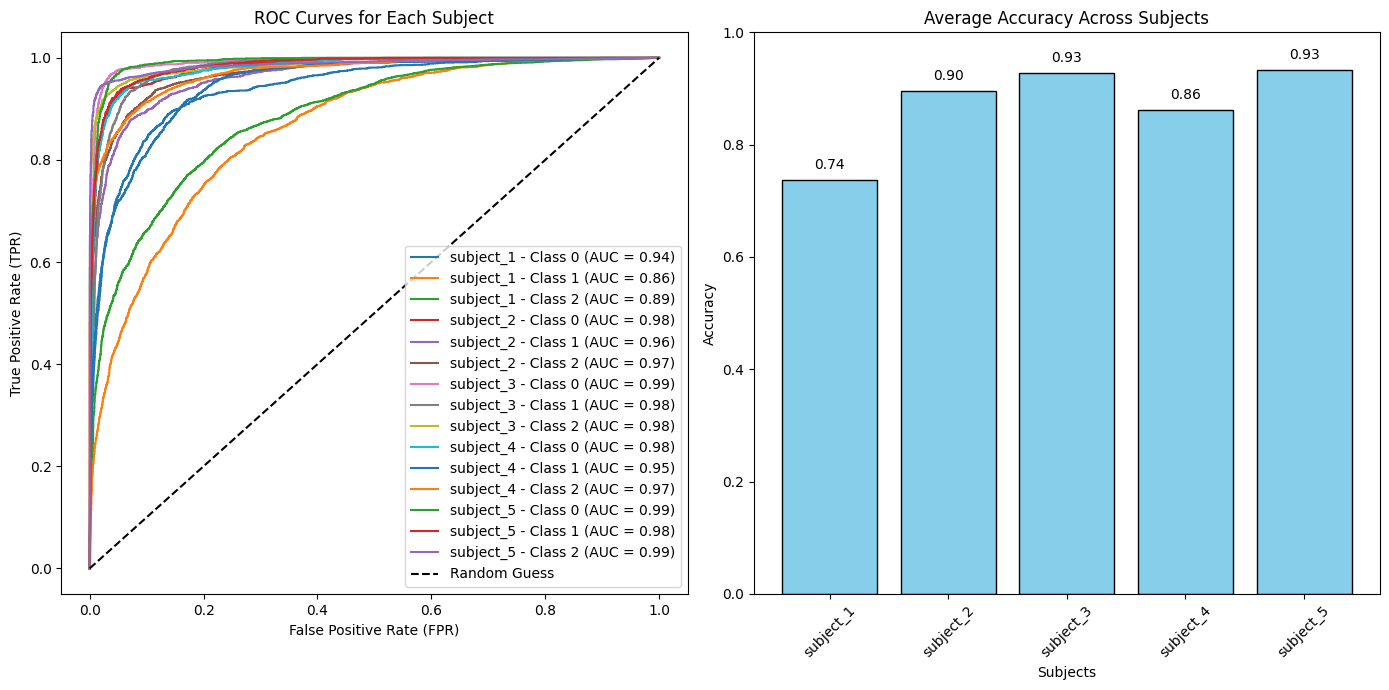

In [ ]:
# Call the updated function with results
plot_roc_auc_and_metrics(results)

## Evaluate Models

### Đánh giá ROC-AUC
- Biểu đồ bên trái thể hiện *ROC Curves* cho từng subject với giá trị AUC (Area Under Curve) tương ứng.
- Các subject đều có kết quả AUC cao, cho thấy mô hình có khả năng phân biệt tốt giữa các class.
- Các class của từng subject có sự khác biệt nhỏ về AUC, nhưng nhìn chung các giá trị đều vượt trội so với đường dự đoán ngẫu nhiên.

### Độ chính xác trung bình trên các subject
- Biểu đồ bên phải thể hiện độ chính xác trung bình (Accuracy) của mô hình trên mỗi subject.
- Mô hình đạt độ chính xác tốt trên tất cả các subject, với độ chính xác cao hơn rõ rệt ở các subject cụ thể.

### Nhận xét
- Mô hình hoạt động ổn định trên các subject với khả năng phân loại chính xác cao.
- Một số class có sự chênh lệch nhẹ về hiệu suất, cần được phân tích thêm để cải thiện tính nhất quán.
- Tổng thể, kết quả cho thấy mô hình có tiềm năng tốt trong việc phân loại trạng thái chú ý từ dữ liệu EEG.